## Project Overview

**Data**

Con Edison network level load data for 90 networks over 4 years. Time of Use categories used in Con Edison's pricing plans.

**Models**

Peak Estimation -> logistic fit, select most predictable networks, get peak threshold for a confidence level

Battery Servicable Load Percent -> percent of max where load above threshold = 4*(max-threshold)

Threshold Dispatch -> matches load above threshold, constrained by power and capacity, threshold can be set given allowable failure rates


**Goal Final Result**

Developed a control scheme for a battery system to lower peak loads cheaper than an equivalent distribution system upgrade. Able to quantify failure rate of battery system. Visualize the result clearly.



## Problem Statement

NYC's energy distribution system needs to be sized according to peak loads which is far greater than the average load.

## Hypothesis

A battery system can save money by lowering peak loads and deferring upgrades.

(Null Hypothesis) - A battery system can not save money by lowering peak loads and deferring upgrades.

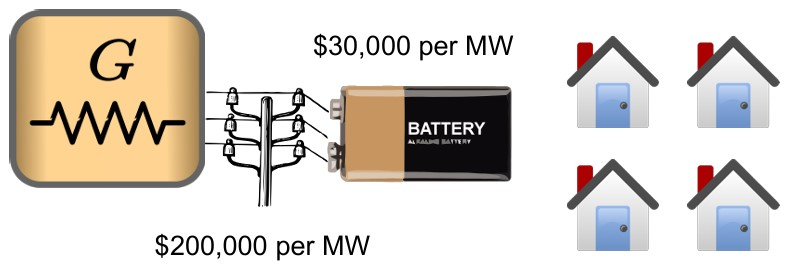

## How I sourced my data and why I chose it

Con Edison provides historical day-ahead forecasted network level load data.

Source: https://coned.maps.arcgis.com/apps/MapSeries/index.html?appid=edce09020bba4f999c06c462e5458ac7

Con Edison standard and time of use rates were manually constructed according to their policy.

Source: https://www.coned.com/en/accounts-billing/your-bill/time-of-use



### Data Set 1 (Load Data)

I chose this dataset since the network load set is complete over 90 substations for 5 years. The data provides a temporal and spatial record of the energy use in Manhattan. I am confident valuable insights can be drawn from this data. I also chose this dataset because I understand the fundemental engineering and infrastructure behind the data which informs my exporation and analysis.

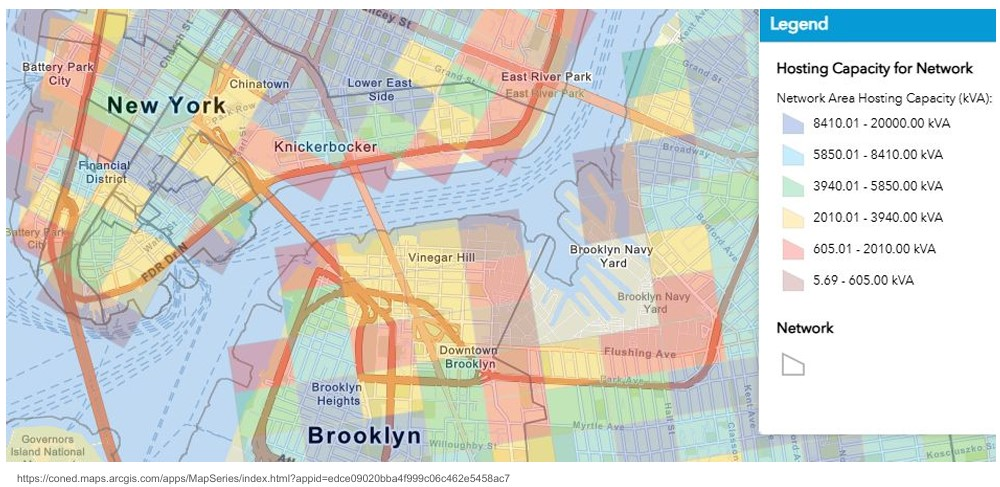

In [ ]:
import pandas as pd
import numpy as np

# Read the CSV files
network2020_df = pd.read_csv('Network_Load_forecasted2020.csv', skiprows=4)
network2021_df = pd.read_csv('Network_Load_forecasted2021.csv', skiprows=3)
network2022_df = pd.read_csv('Network_Load_forecasted2022.csv', skiprows=3)
network2023_df = pd.read_csv('Network_Load_forecasted2023.csv', skiprows=3)
network2024_df = pd.read_csv('Network_Load_forecasted2024.csv', skiprows=4)

print(network2020_df.shape)
print(network2021_df.shape)
print(network2022_df.shape)
print(network2023_df.shape)
print(network2024_df.shape)

# List of all network dataframes
dfs = [network2020_df, network2021_df, network2022_df, network2023_df, network2024_df]

# Set the hourly index for each dataframe based on its year
network2020_df.index = pd.date_range(start='2020-01-01 00:00:00', periods=len(network2020_df), freq='h')
network2021_df.index = pd.date_range(start='2021-01-01 00:00:00', periods=len(network2021_df), freq='h')
network2022_df.index = pd.date_range(start='2022-01-01 00:00:00', periods=len(network2022_df), freq='h')
network2023_df.index = pd.date_range(start='2023-01-01 00:00:00', periods=len(network2023_df), freq='h')
network2024_df.index = pd.date_range(start='2024-01-01 00:00:00', periods=len(network2024_df), freq='h')

# Concatenate the dataframes chronologically
network_df = pd.concat([network2020_df, network2021_df, network2022_df,
                          network2023_df, network2024_df])

# Check the results
print(network_df.head())
print("=" * 70)
print(network_df.info())
print("=" * 70)


(8784, 97)
(8760, 97)
(8760, 97)
(8760, 97)
(8784, 97)
                          DateTime  Battery Park City  Bay Ridge  Beekman  \
2020-01-01 00:00:00  1/1/2020 0:00                 24        107       40   
2020-01-01 01:00:00  1/1/2020 1:00                 22         97       38   
2020-01-01 02:00:00  1/1/2020 2:00                 22         92       37   
2020-01-01 03:00:00  1/1/2020 3:00                 21         91       37   
2020-01-01 04:00:00  1/1/2020 4:00                 21         89       36   

                     Borden  Borough Hall  Bowling Green  Brighton Beach  \
2020-01-01 00:00:00      72           141             42              45   
2020-01-01 01:00:00      68           136             40              43   
2020-01-01 02:00:00      63           133             37              41   
2020-01-01 03:00:00      61           132             36              40   
2020-01-01 04:00:00      61           132             35              39   

                     Buch

In [ ]:
# Filter out rows where the index is February 29
network_df = network_df[~((network_df.index.month == 2) & (network_df.index.day == 29))]
network_df = network_df[~((network_df.index.year == 2025))]

print(network_df.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2020-01-01 00:00:00 to 2024-12-31 23:00:00
Data columns (total 97 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   DateTime            43800 non-null  object
 1   Battery Park City   43800 non-null  int64 
 2   Bay Ridge           43800 non-null  int64 
 3   Beekman             43800 non-null  int64 
 4   Borden              43800 non-null  int64 
 5   Borough Hall        43800 non-null  int64 
 6   Bowling Green       43800 non-null  int64 
 7   Brighton Beach      43800 non-null  int64 
 8   Buchanan            43800 non-null  int64 
 9   Canal               43800 non-null  int64 
 10  Cedar Street        43800 non-null  int64 
 11  Central Bronx       43800 non-null  int64 
 12  Central Park        43800 non-null  int64 
 13  Chelsea             43800 non-null  int64 
 14  City Hall           43800 non-null  int64 
 15  Columbus Circle     43800 non-null 

### Data Set 2 (Time of Use Categories)

This dataset was manually constructed from Con Edision's publically available pricing information. This labels all days of the year as 'off-peak', 'peak', or 'super-peak'. I was interested in these categories since this is how customers are directly affected by peak pricing and how peak load is communicated to customers. It also allows me to have a reasonable prior for when peak load will be.

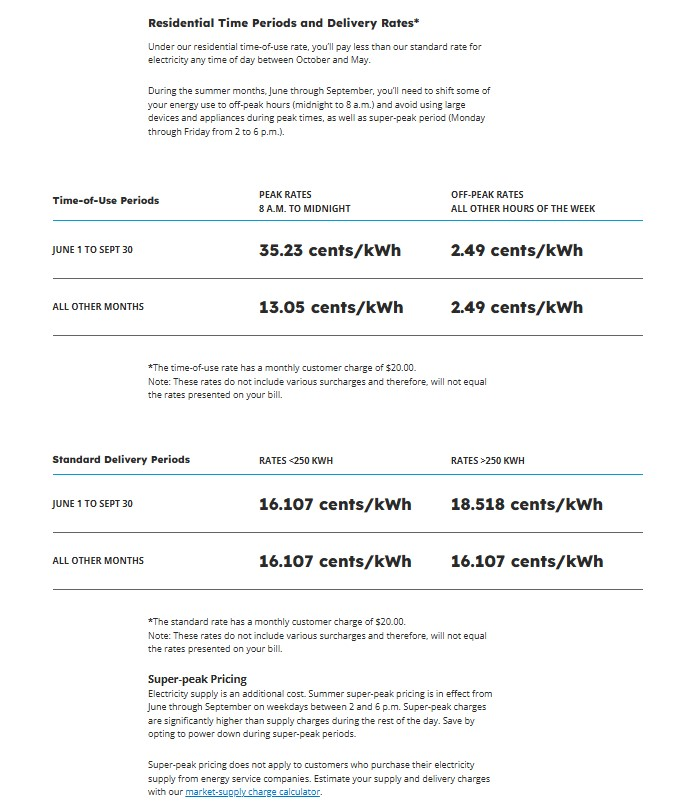

In [ ]:
# Create an hourly DateTime index for a full year (8760 hours).
date_time = pd.date_range(start='2020-01-01', end='2025-01-01', freq='h')

# Delivery dataframe: create using the date_time index directly
delivery_df = pd.DataFrame(index=date_time)
delivery_df = delivery_df[~((delivery_df.index.month == 2) & (delivery_df.index.day == 29))]
delivery_df = delivery_df[~((delivery_df.index.year == 2025))]


# Step 1: Create a new, proper hourly index for each non-leap year.
def non_leap_year_index(year):
    # Generate a date range for the given year from Jan 1 to Dec 31 (hourly)
    rng = pd.date_range(start=f'{year}-01-01 00:00:00', end=f'{year}-12-31 23:00:00', freq='H')
    # Remove Feb 29 if it exists
    return rng[~((rng.month == 2) & (rng.day == 29))]

# Build an index for the years 2020 through 2024
new_index = []
for year in [2020, 2021, 2022, 2023, 2024]:
    new_index.append(non_leap_year_index(year))
new_index = new_index[0].append(new_index[1:])  # Concatenate all the year indices


# 2) Helper functions to classify hours and months
def is_summer(month):
    """Return True if month is June, July, August, or September."""
    return month in (6, 7, 8, 9)

def is_peak_hour(hour):
    """Return True if hour is from 8 a.m. (inclusive) up to midnight (exclusive)."""
    return 8 <= hour < 24

def get_time_of_use_rate(month, hour):
    """
    Return the Time-of-Use rate (in cents/kWh) based on:
      - Summer (June–September) vs. Non-summer,
      - Peak (8 a.m.–midnight) vs. Off-peak (midnight–8 a.m.)
    """
    if is_summer(month):
        return 35.23 if is_peak_hour(hour) else 2.49
    else:
        return 13.05 if is_peak_hour(hour) else 2.49

def get_standard_delivery_rate_lt250(month):
    """Return the Standard Delivery Rate for <250 kW (in cents/kWh)."""
    return 16.107

# 3) Apply the functions using the index of the DataFrame
delivery_df['time_of_use_rate'] = delivery_df.index.map(
    lambda dt: get_time_of_use_rate(dt.month, dt.hour)
)
delivery_df['standard_rate'] = delivery_df.index.map(
    lambda dt: get_standard_delivery_rate_lt250(dt.month)
)
delivery_df['Peak_bool'] = delivery_df.index.map(
    lambda dt: 1 if is_peak_hour(dt.hour) else 0
)

print(delivery_df.info())
print(delivery_df.tail())


<ipython-input-3-e781548872d4>:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rng = pd.date_range(start=f'{year}-01-01 00:00:00', end=f'{year}-12-31 23:00:00', freq='H')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2020-01-01 00:00:00 to 2024-12-31 23:00:00
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time_of_use_rate  43800 non-null  float64
 1   standard_rate     43800 non-null  float64
 2   Peak_bool         43800 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 1.3 MB
None
                     time_of_use_rate  standard_rate  Peak_bool
2024-12-31 19:00:00             13.05         16.107          1
2024-12-31 20:00:00             13.05         16.107          1
2024-12-31 21:00:00             13.05         16.107          1
2024-12-31 22:00:00             13.05         16.107          1
2024-12-31 23:00:00             13.05         16.107          1


I also added 'Day' and 'Hour' columns

In [ ]:
# Assume delivery_df, supply_df, and network_df have already been read
# Outer merge to include all datetime indices
merged_outer = pd.merge(delivery_df, network_df, left_index=True, right_index=True, how='outer')

merged_outer.index = range(len(merged_outer))

# Create an "Hour" column using index modulo 24
merged_outer['Hour'] = merged_outer.index % 24
# Create a 'Day' column based on sequential hour index (each day = 24 hours)
merged_outer['Day'] = merged_outer.index // 24

# Find rows with missing data (i.e. dates not shared by all 3 DataFrames)
missing_dates = merged_outer[merged_outer.isnull().any(axis=1)]
print("Dates missing from at least one DataFrame:")
print(missing_dates.index)

# If you want to see a summary, you could also do:
print("\nNumber of missing dates:", missing_dates.shape[0])

print(merged_outer.head())

Dates missing from at least one DataFrame:
Index([], dtype='int64')

Number of missing dates: 0
   time_of_use_rate  standard_rate  Peak_bool       DateTime  \
0              2.49         16.107          0  1/1/2020 0:00   
1              2.49         16.107          0  1/1/2020 1:00   
2              2.49         16.107          0  1/1/2020 2:00   
3              2.49         16.107          0  1/1/2020 3:00   
4              2.49         16.107          0  1/1/2020 4:00   

   Battery Park City  Bay Ridge  Beekman  Borden  Borough Hall  Bowling Green  \
0                 24        107       40      72           141             42   
1                 22         97       38      68           136             40   
2                 22         92       37      63           133             37   
3                 21         91       37      61           132             36   
4                 21         89       36      61           132             35   

   ...  Parkchester #2  Plymouth

In [ ]:
# Count the number of rows where "standard rate" equals 35.23
count_value = merged_outer[merged_outer['time_of_use_rate'] == 35.23].shape[0]
print("Count of rows with standard rate 35.23:", count_value)


Count of rows with standard rate 35.23: 9760


## Exploratory Data Analysis

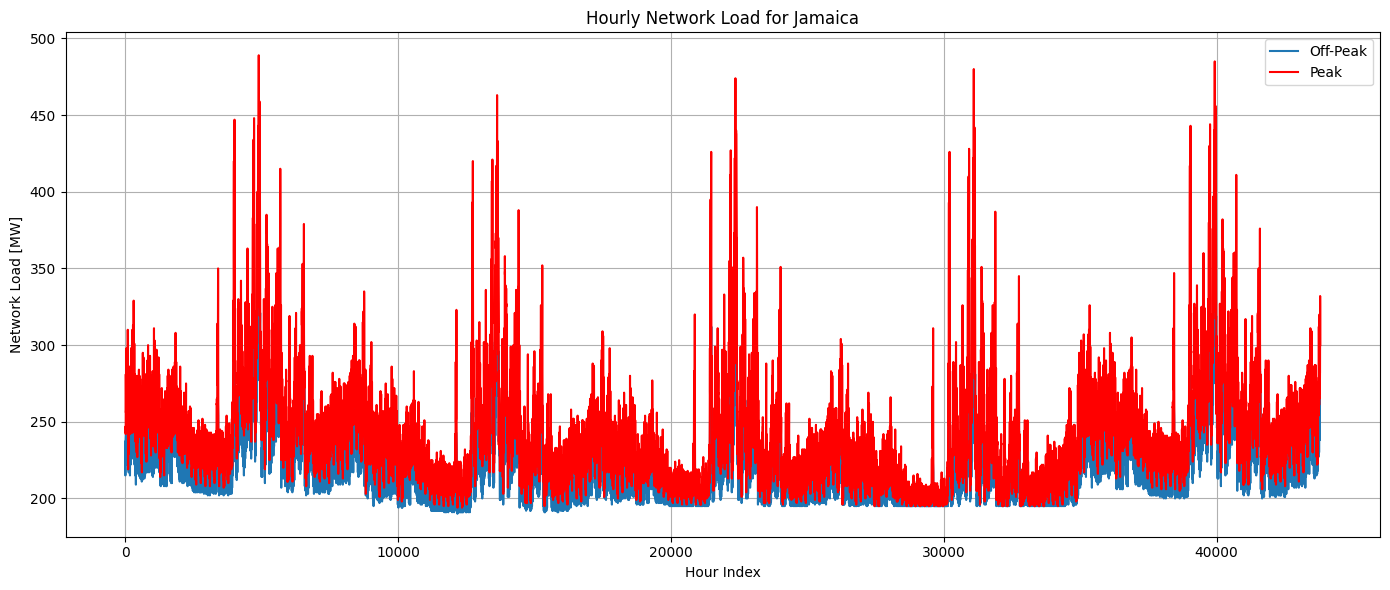

Overall Max Load to Average Load Ratio: 2.0904666417129993


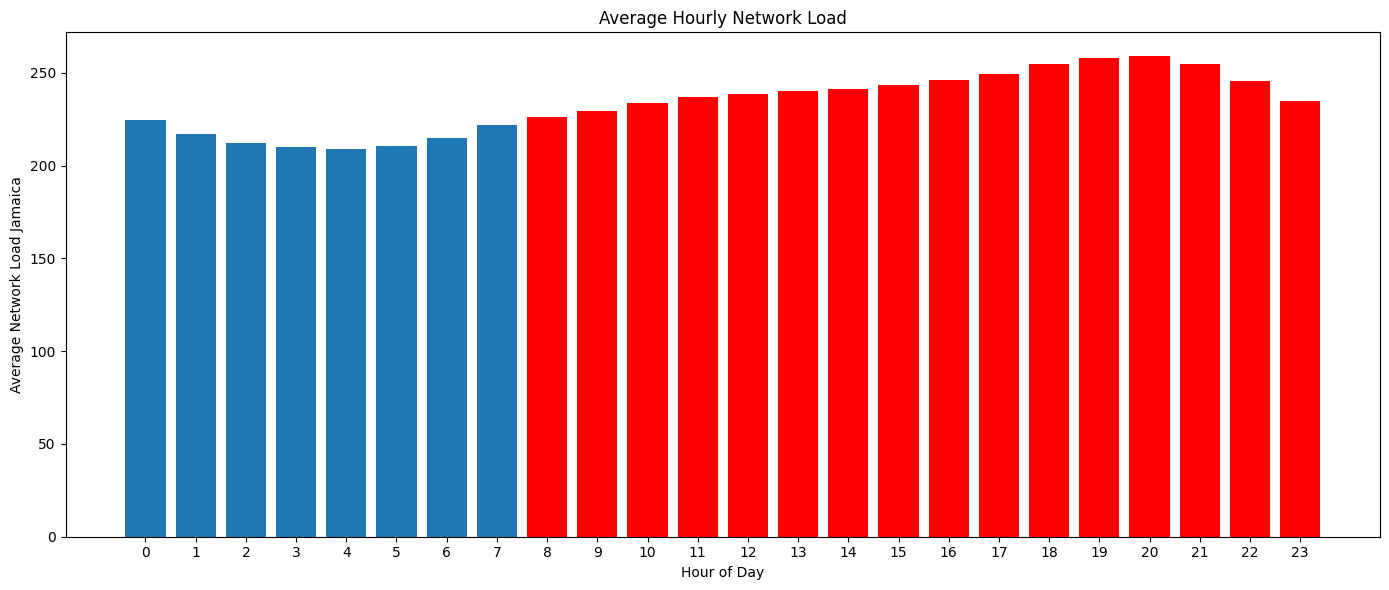

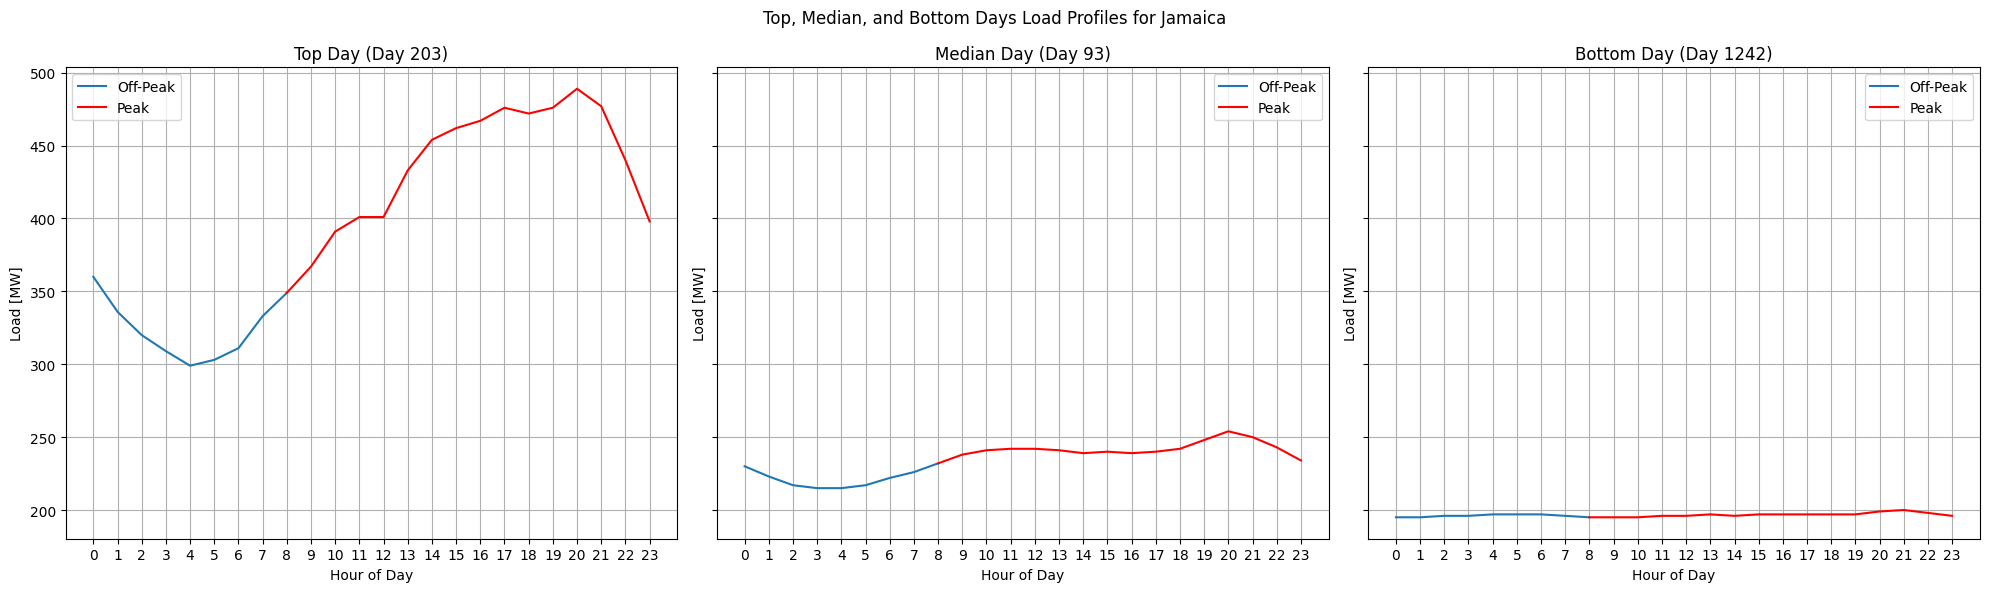

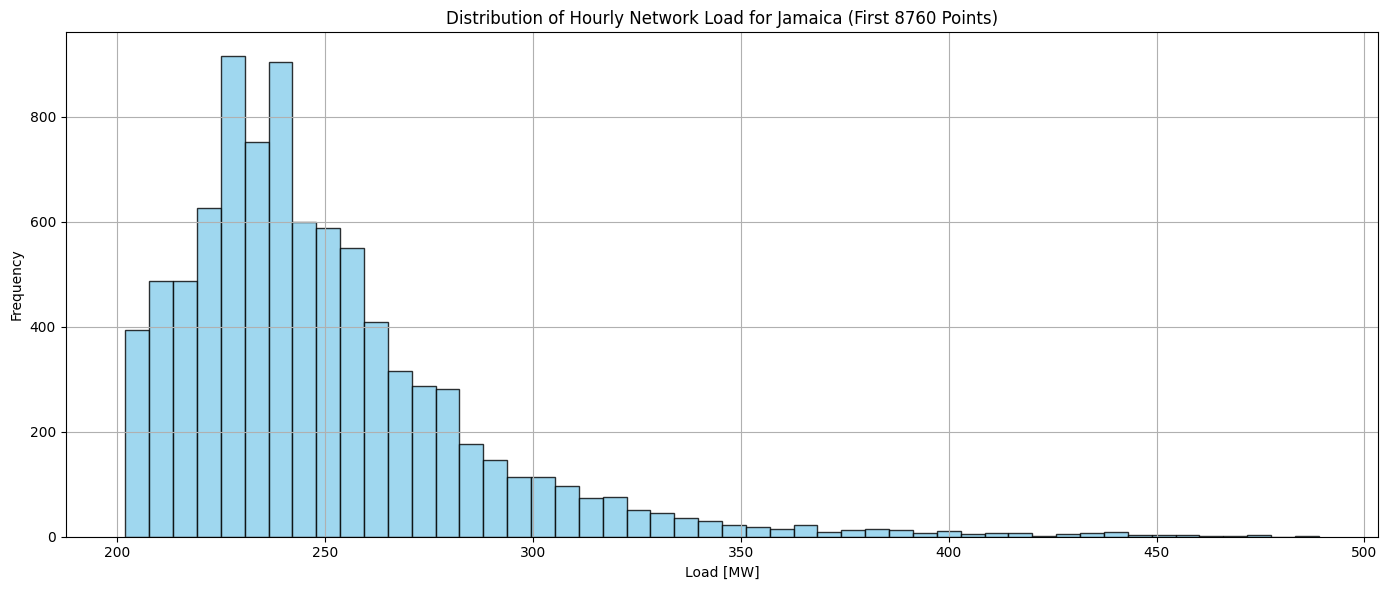

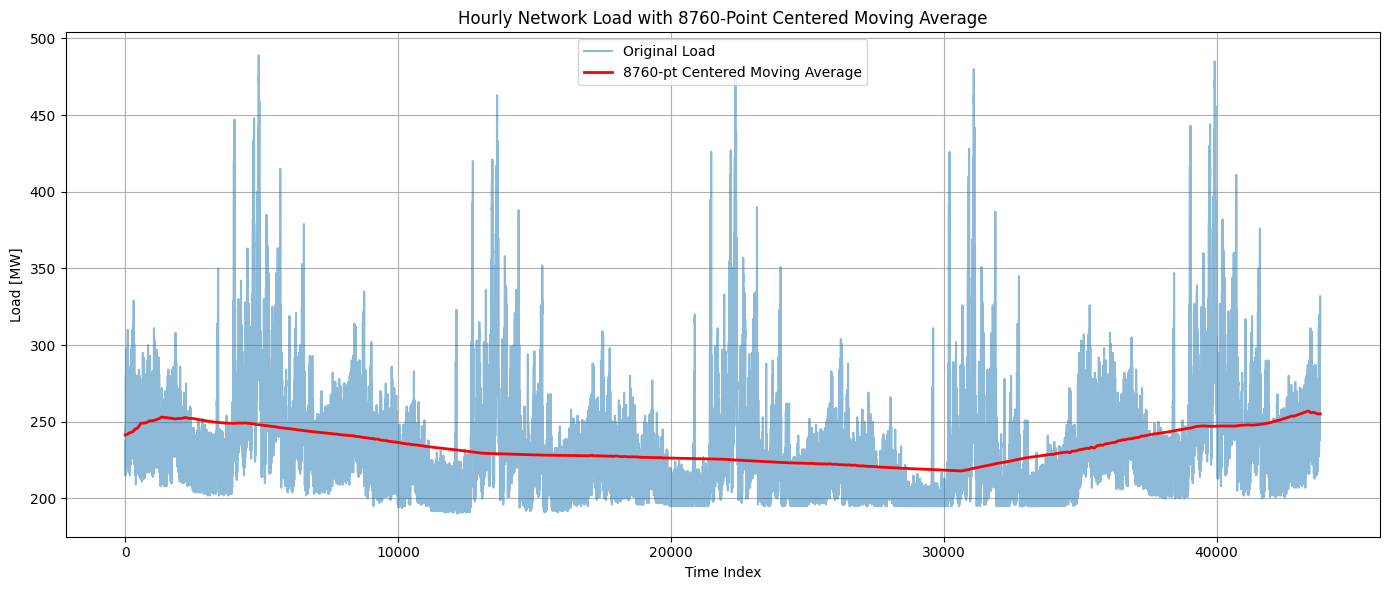

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

merged_outer.index = range(len(merged_outer))

# Visualization 1: Time Series of Hourly Network Load (merged_outer)
plt.figure(figsize=(14, 6))
# Split merged_outer into off-peak and peak based on its Peak_bool column
off_peak_net = merged_outer[merged_outer['Peak_bool'] == 0]
peak_net = merged_outer[merged_outer['Peak_bool'] == 1]

plt.plot(off_peak_net.index, off_peak_net['Jamaica'],
         label='Off-Peak', color='tab:blue')
plt.plot(peak_net.index, peak_net['Jamaica'],
         label='Peak', color='red')

plt.title('Hourly Network Load for Jamaica')
plt.xlabel('Hour Index')
plt.ylabel('Network Load [MW]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Compute the overall ratio of maximum load to average load for the entire period.
overall_max = merged_outer['Jamaica'].max()
overall_avg = merged_outer['Jamaica'].mean()
overall_ratio = overall_max / overall_avg
print("Overall Max Load to Average Load Ratio:", overall_ratio)

# Visualization 2: Average Network Load by Hour
avg_by_hour_net = merged_outer.groupby('Hour')['Jamaica'].mean().reset_index()

# Create a color list: red for peak hours (hour>=8) and blue for off-peak hours (hour<8)
colors_net = ['red' if hour >= 8 else 'tab:blue' for hour in avg_by_hour_net['Hour']]

plt.figure(figsize=(14, 6))
plt.xticks(range(24))
plt.bar(avg_by_hour_net['Hour'], avg_by_hour_net['Jamaica'], color=colors_net)
plt.title('Average Hourly Network Load')
plt.xlabel('Hour of Day')
plt.ylabel('Average Network Load Jamaica')
plt.tight_layout()
plt.show()

# Visualization 3: Highest, Median, and Lowest Load Days
# Compute the daily maximum load for Jamaica
daily_max = merged_outer.groupby('Day')['Jamaica'].max()

# Identify the top, median, and bottom days based on daily maximum load
top_day = daily_max.idxmax()
bottom_day = daily_max.idxmin()
median_value = daily_max.median()
median_day = (daily_max - median_value).abs().idxmin()

# Prepare the days to plot and their corresponding titles
days_to_plot = [top_day, median_day, bottom_day]
titles = [f"Top Day (Day {top_day})", f"Median Day (Day {median_day})", f"Bottom Day (Day {bottom_day})"]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for ax, day, title in zip(axes, days_to_plot, titles):
    # Filter the DataFrame for the current day
    day_data = merged_outer[merged_outer['Day'] == day].copy()
    # Create an 'Hour' column (assuming the index corresponds to hours in order)
    day_data['Hour'] = day_data.index % 24

    # Split data into off-peak (hours 0-7) and peak (hours 8-23)
    off_peak_day = day_data[day_data['Hour'] <= 8]
    peak_day = day_data[day_data['Hour'] >= 8]

    # Plot off-peak in blue and peak in red
    ax.plot(off_peak_day['Hour'], off_peak_day['Jamaica'], label='Off-Peak', color='tab:blue')
    ax.plot(peak_day['Hour'], peak_day['Jamaica'], label='Peak', color='red')

    ax.set_xticks(range(24))
    ax.set_title(title)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Load [MW]')
    ax.legend()
    ax.grid(True)

plt.suptitle('Top, Median, and Bottom Days Load Profiles for Jamaica')
plt.tight_layout()
plt.show()

# Visualization 4: Distribution of Hourly Loads as a Histogram for the first 8760 points
plt.figure(figsize=(14, 6))
data_subset = merged_outer['Jamaica'].iloc[:8760]  # Select only the first 8760 data points
plt.hist(data_subset, bins=50, color='skyblue', edgecolor='black', alpha=0.8)
plt.title('Distribution of Hourly Network Load for Jamaica (First 8760 Points)')
plt.xlabel('Load [MW]')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualization 5: Growth Trend using a centered moving average
# Define the window size (8760 hours, representing one year)
window_size = 8760

# Compute the centered moving average with min_periods=1 to include boundary values
moving_avg = merged_outer['Jamaica'].rolling(window=window_size, center=True, min_periods=1).mean()

# Plot the original load and the moving average
plt.figure(figsize=(14, 6))
plt.plot(merged_outer.index, merged_outer['Jamaica'], alpha=0.5, label='Original Load')
plt.plot(merged_outer.index, moving_avg, color='red', linewidth=2,
         label=f'{window_size}-pt Centered Moving Average')
plt.xlabel('Time Index')
plt.ylabel('Load [MW]')
plt.title('Hourly Network Load with 8760-Point Centered Moving Average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Data Preparation

# Use .iloc to slice columns by index, then select only numeric columns
subset_df = merged_outer.iloc[:, 4:-2]
numeric_subset = subset_df.select_dtypes(include=np.number)

# Determine the top networks by maximum load using the numeric columns
max_loads = numeric_subset.max()  # max for each column
top_areas = max_loads.sort_values(ascending=False).head(50).index.tolist()

# Also keep some key columns and the top 10 networks in a new DataFrame
new_cols = ['DateTime', 'Day', 'Hour', 'standard_rate', 'time_of_use_rate', 'Peak_bool'] + top_areas
loads_df = merged_outer[new_cols].copy()

loads_df.info()
loads_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 56 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DateTime            43800 non-null  object 
 1   Day                 43800 non-null  int64  
 2   Hour                43800 non-null  int64  
 3   standard_rate       43800 non-null  float64
 4   time_of_use_rate    43800 non-null  float64
 5   Peak_bool           43800 non-null  int64  
 6   Jamaica             43800 non-null  int64  
 7   Flushing            43800 non-null  int64  
 8   Williamsburg        43800 non-null  int64  
 9   Borough Hall        43800 non-null  int64  
 10  Richmond Hill       43800 non-null  int64  
 11  Yorkville           43800 non-null  int64  
 12  Flatbush            43800 non-null  int64  
 13  Fordham             43800 non-null  int64  
 14  Pennsylvania        43800 non-null  int64  
 15  Maspeth             43800 non-null  int64  
 16  Bay 

,Day,Hour,standard_rate,time_of_use_rate,Peak_bool,Jamaica,Flushing,Williamsburg,Borough Hall,Richmond Hill,...,Lincoln Square,Elmsford No. 2,Sutton,Plaza,Times Square,Columbus Circle,Grasslands,Buchanan,Woodrow,Brighton Beach
count,43800.000000,43800.000000,4.380000e+04,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,...,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,912.000000,11.500000,1.610700e+01,14.472393,0.666667,233.919064,155.734384,144.072808,152.755845,154.617785,...,79.113059,64.319338,62.372237,69.663813,65.635845,66.100320,54.478493,51.108767,30.954909,46.441758
std,526.838056,6.922266,5.069780e-12,12.032189,0.471410,35.916850,39.456667,34.913026,33.100286,36.740452,...,15.708870,15.877284,18.411587,16.213762,17.492254,14.512205,10.158824,11.135598,13.312821,10.885835
min,0.000000,0.000000,1.610700e+01,2.490000,0.000000,190.000000,91.000000,106.000000,119.000000,77.000000,...,60.000000,39.000000,40.000000,46.000000,45.000000,41.000000,44.000000,33.000000,16.000000,32.000000
25%,456.000000,5.750000,1.610700e+01,2.490000,0.000000,209.000000,130.000000,120.000000,128.000000,130.000000,...,68.000000,53.000000,49.000000,57.000000,52.000000,55.000000,47.000000,43.000000,23.000000,39.000000
50%,912.000000,11.500000,1.610700e+01,13.050000,1.000000,225.000000,148.000000,135.000000,144.000000,147.000000,...,76.000000,62.000000,55.000000,64.000000,58.000000,64.000000,51.000000,49.000000,27.000000,44.000000
75%,1368.000000,17.250000,1.610700e+01,13.050000,1.000000,248.000000,169.000000,158.000000,166.000000,170.000000,...,84.000000,71.000000,73.000000,80.000000,78.000000,75.000000,58.000000,56.000000,34.000000,51.000000
max,1824.000000,23.000000,1.610700e+01,35.230000,1.000000,489.000000,380.000000,361.000000,352.000000,350.000000,...,159.000000,158.000000,145.000000,142.000000,132.000000,129.000000,127.000000,127.000000,114.000000,113.000000


## Developing Numerical Models, Validating Models, and Visualizing Outcomes

### Peak Estimation Model


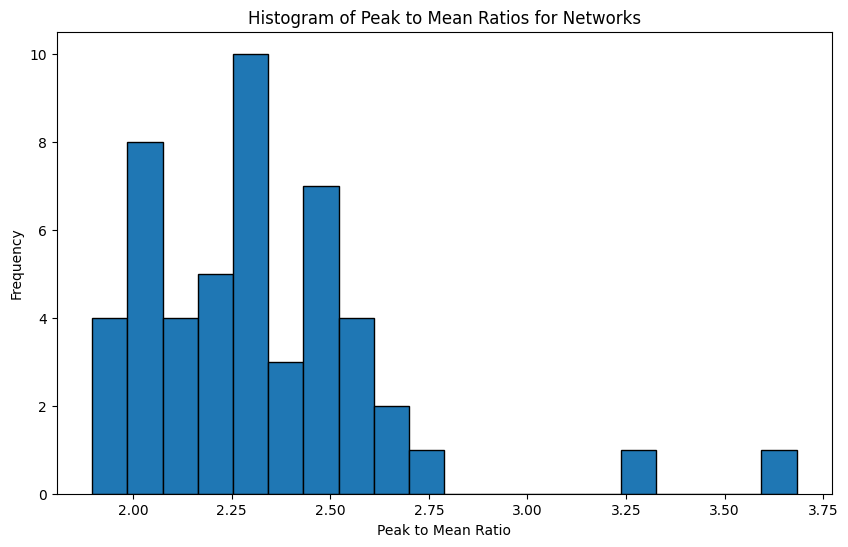

In [ ]:
# Calculate the peak-to-mean ratio for each network.
peak_to_mean_ratios = {}
for area in top_areas:
    peak = loads_df[area].max()
    mean_val = loads_df[area].mean()
    # Avoid division by zero
    ratio = peak / mean_val if mean_val != 0 else np.nan
    peak_to_mean_ratios[area] = ratio

# Create a list of ratios (ignoring any that might be None).
ratios_list = [r for r in peak_to_mean_ratios.values() if r is not None]

# Plot the histogram.
plt.figure(figsize=(10, 6))
plt.hist(ratios_list, bins=20, edgecolor='black')
plt.xlabel('Peak to Mean Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Peak to Mean Ratios for Networks')
plt.show()

In [ ]:
# Calculate the percentage of networks with a ratio over 3.
total_networks = len(peak_to_mean_ratios)
num_over_3 = sum(1 for ratio in peak_to_mean_ratios.values() if ratio >= 3)
percent_over_3 = 100 * num_over_3 / total_networks

print(f"{percent_over_3:.2f}% of networks have a peak-to-mean ratio of 3 or higher.")

# Create a new DataFrame with outlier networks (ratio > 3) dropped.
invalid_networks = [col for col in top_areas if peak_to_mean_ratios[col] >= 3]
print(f"Networks with peak-to-mean ratio >= 3: {invalid_networks}")
try:
  loads_df = loads_df.drop(columns=invalid_networks)
except KeyError as e:
  print(f"Error dropping columns: {e}")

for area in invalid_networks:
    top_areas.remove(area)

# Optionally display the head of the new DataFrame
print(loads_df.columns)
print(top_areas)

4.00% of networks have a peak-to-mean ratio of 3 or higher.
Networks with peak-to-mean ratio >= 3: ['Pennsylvania', 'Woodrow']
Index(['DateTime', 'Day', 'Hour', 'standard_rate', 'time_of_use_rate',
       'Peak_bool', 'Jamaica', 'Flushing', 'Williamsburg', 'Borough Hall',
       'Richmond Hill', 'Yorkville', 'Flatbush', 'Fordham', 'Maspeth',
       'Bay Ridge', 'Madison Square', 'Lenox Hill', 'Long Island City',
       'White Plains', 'West Bronx', 'Cooper Square', 'Ridgewood', 'Chelsea',
       'Crown Heights', 'Park Slope', 'Rego Park', 'Granite Hill', 'Fox Hills',
       'Harlem', 'Harrison', 'Southeast Bronx', 'Jackson Heights',
       'Washington Street', 'Central Park', 'Central Bronx',
       'Washington Heights', 'Grand Central', 'Fresh Kills', 'Triboro',
       'Ocean Parkway', 'Sheepshead Bay', 'Sheridan Square', 'Borden',
       'City Hall', 'Lincoln Square', 'Elmsford No. 2', 'Sutton', 'Plaza',
       'Times Square', 'Columbus Circle', 'Grasslands', 'Buchanan',
       'Brig

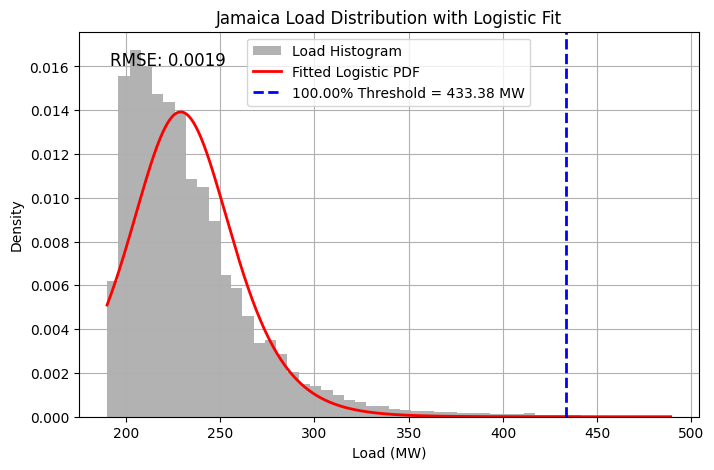

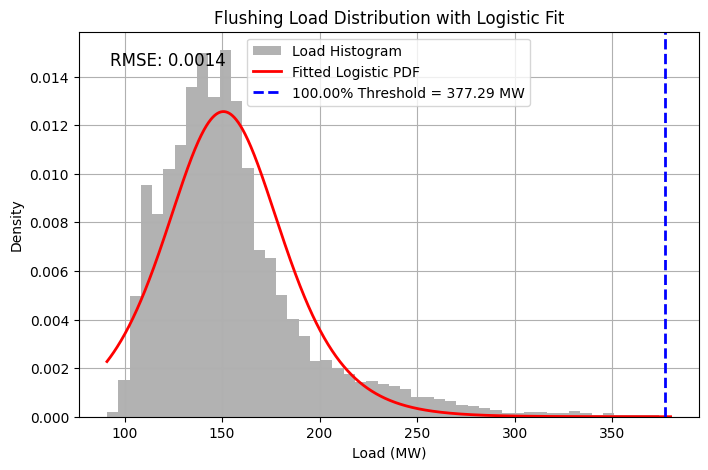

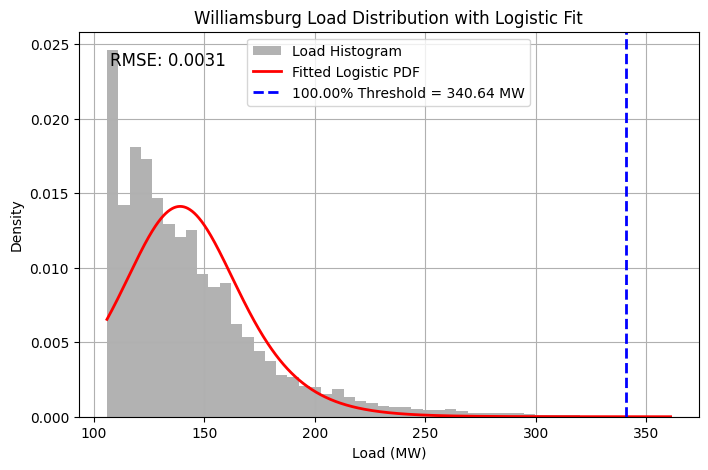

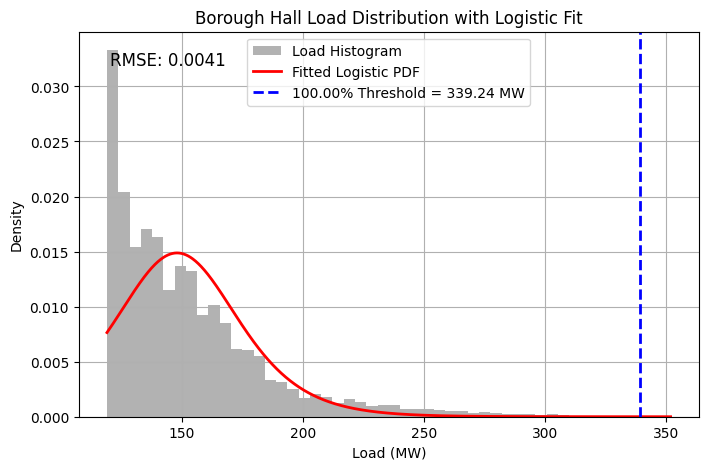

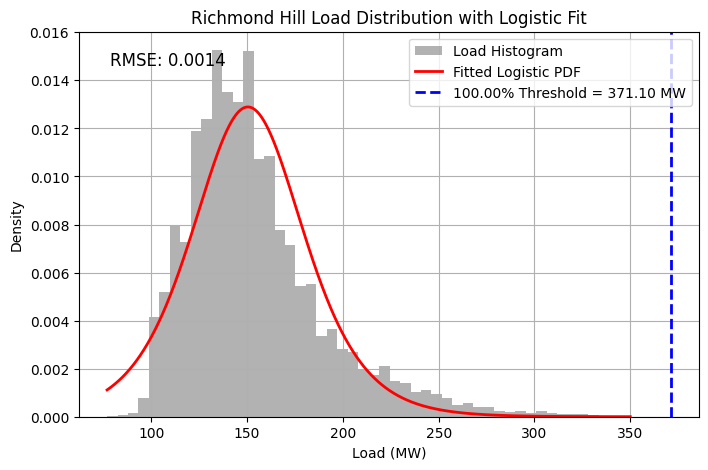

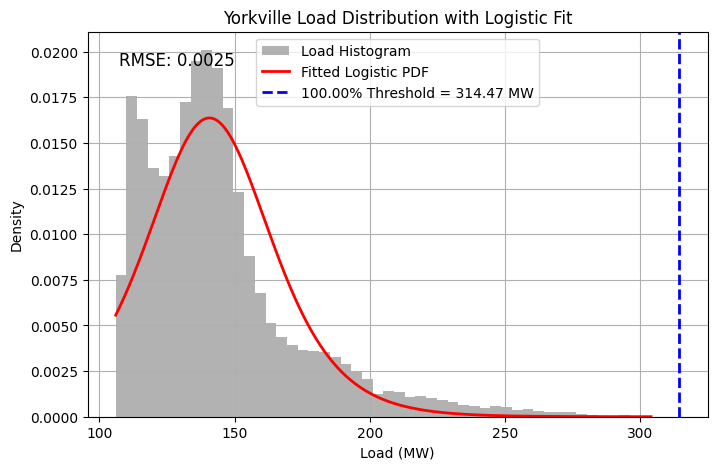

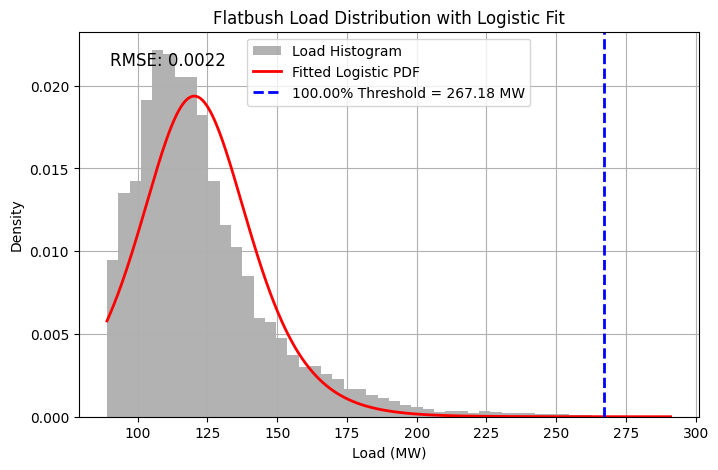

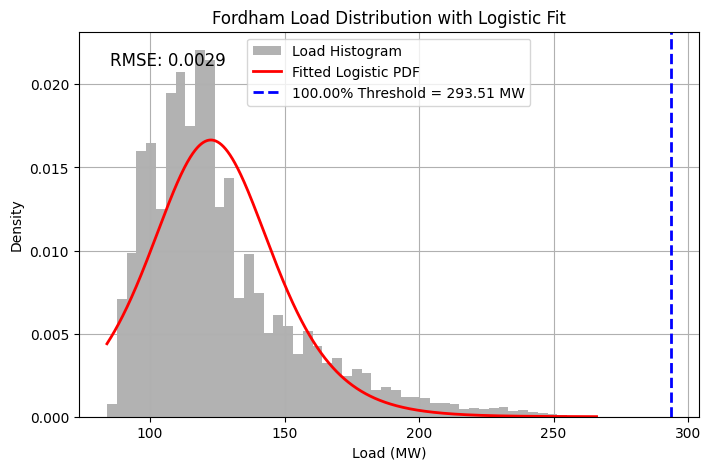

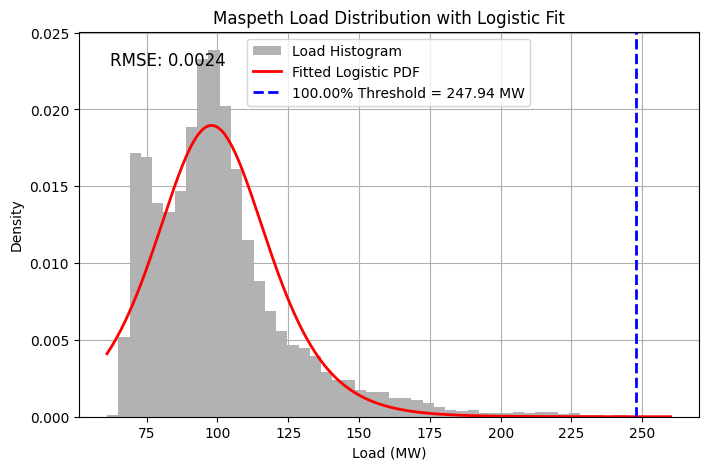

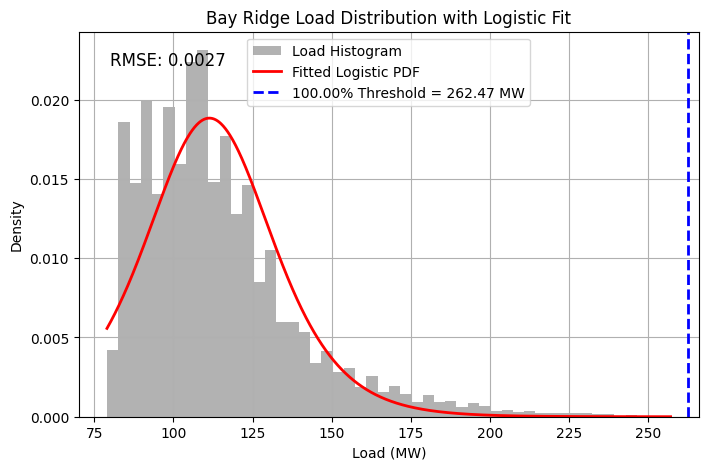

RMSE for each network from lowest to highest:
Flushing: RMSE = 0.0014 | 377.29 MW threshold at 100.00% confidence (max load 380.00 MW)
Richmond Hill: RMSE = 0.0014 | 371.10 MW threshold at 100.00% confidence (max load 350.00 MW)
Jamaica: RMSE = 0.0019 | 433.38 MW threshold at 100.00% confidence (max load 489.00 MW)
Ridgewood: RMSE = 0.0021 | 252.12 MW threshold at 100.00% confidence (max load 234.00 MW)
Flatbush: RMSE = 0.0022 | 267.18 MW threshold at 100.00% confidence (max load 291.00 MW)
Lenox Hill: RMSE = 0.0023 | 282.01 MW threshold at 100.00% confidence (max load 246.00 MW)
Southeast Bronx: RMSE = 0.0023 | 242.06 MW threshold at 100.00% confidence (max load 210.00 MW)
Maspeth: RMSE = 0.0024 | 247.94 MW threshold at 100.00% confidence (max load 260.00 MW)
Yorkville: RMSE = 0.0025 | 314.47 MW threshold at 100.00% confidence (max load 304.00 MW)
Long Island City: RMSE = 0.0025 | 260.43 MW threshold at 100.00% confidence (max load 244.00 MW)
Washington Street: RMSE = 0.0026 | 194.24 

In [ ]:
from scipy.stats import logistic
import numpy as np
import matplotlib.pyplot as plt

# Assuming top_areas and loads_df are already defined
# For RMSE calculation, we need to compute the differences between the histogram density values and the fitted logistic PDF.
def compute_rmse(data, loc, scale, bins=50):
    # Compute histogram (density=True makes the integral over bins equal 1)
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    # Compute bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Evaluate the logistic PDF at these centers
    pdf_at_bins = logistic.pdf(bin_centers, loc=loc, scale=scale)
    # Compute RMSE between histogram and fitted PDF values
    rmse = np.sqrt(np.mean((counts - pdf_at_bins) ** 2))
    return rmse

# Set the confidence level for the threshold (e.g., 99.9% here)
confidence_level = 87599 / 87600

# Dictionaries to hold the threshold and RMSE for each network
thresholds_all_data = {}
rmse_all = {}

# Loop over each network in top_areas
for area in top_areas:
    # Get all the data points for the network
    data = loads_df[area].values
    # Fit a logistic distribution to the data
    loc, scale = logistic.fit(data)
    # Compute the threshold from the full distribution
    threshold_value = logistic.ppf(confidence_level, loc=loc, scale=scale)
    thresholds_all_data[area] = threshold_value

    # Create an x-axis that spans the range of the data
    x = np.linspace(data.min(), data.max(), 1000)
    # Calculate the logistic PDF values
    pdf_vals = logistic.pdf(x, loc=loc, scale=scale)

    # Calculate RMSE using the histogram bin centers
    rmse = compute_rmse(data, loc, scale, bins=50)
    rmse_all[area] = rmse

    # Plot histogram of the data with the fitted logistic PDF overlaid
    if area in ['Jamaica', 'Flushing', 'Williamsburg', 'Borough Hall', 'Richmond Hill', 'Yorkville', 'Flatbush', 'Fordham', 'Maspeth', 'Bay Ridge']:
      plt.figure(figsize=(8, 5))
      plt.hist(data, bins=50, density=True, alpha=0.6, color='gray', label='Load Histogram')
      plt.plot(x, pdf_vals, 'r-', lw=2, label='Fitted Logistic PDF')
      plt.axvline(threshold_value, color='blue', linestyle='--', lw=2,
                  label=f"{confidence_level*100:.2f}% Threshold = {threshold_value:.2f} MW")
      # Annotate RMSE on the graph (positioned at top left of the axes)
      plt.text(0.05, 0.95, f'RMSE: {rmse:.4f}', transform=plt.gca().transAxes,
              fontsize=12, verticalalignment='top')
      plt.title(f"{area} Load Distribution with Logistic Fit")
      plt.xlabel("Load (MW)")
      plt.ylabel("Density")
      plt.legend()
      plt.grid(True)
      plt.show()

# Print the threshold and RMSE for each network sorted by RMSE (lowest to highest)
sorted_rmse = sorted(rmse_all.items(), key=lambda x: x[1])
print("RMSE for each network from lowest to highest:")
for area, rmse in sorted_rmse:
    max_load = loads_df[area].max()
    threshold_value = thresholds_all_data[area]
    print(f"{area}: RMSE = {rmse:.4f} | {threshold_value:.2f} MW threshold at {confidence_level*100:.2f}% confidence (max load {max_load:.2f} MW)")


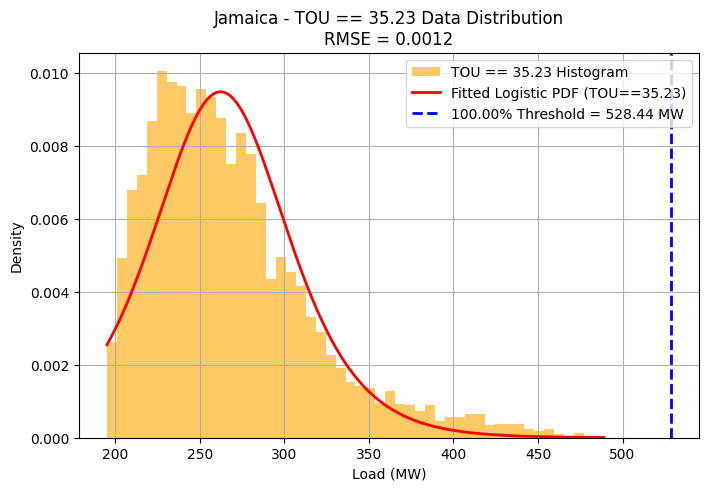

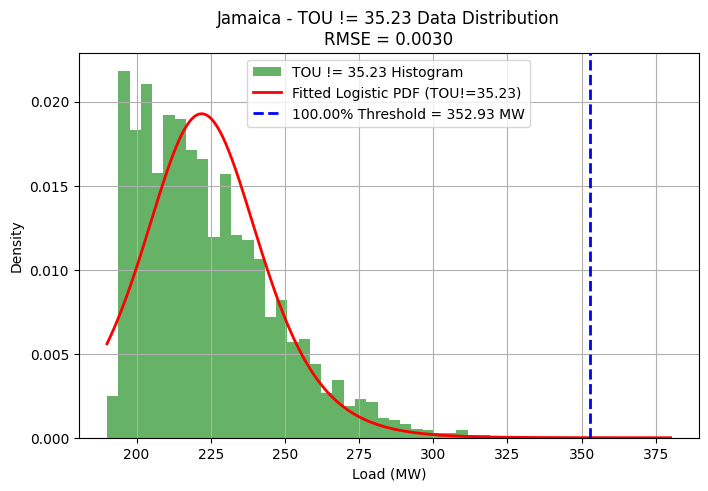

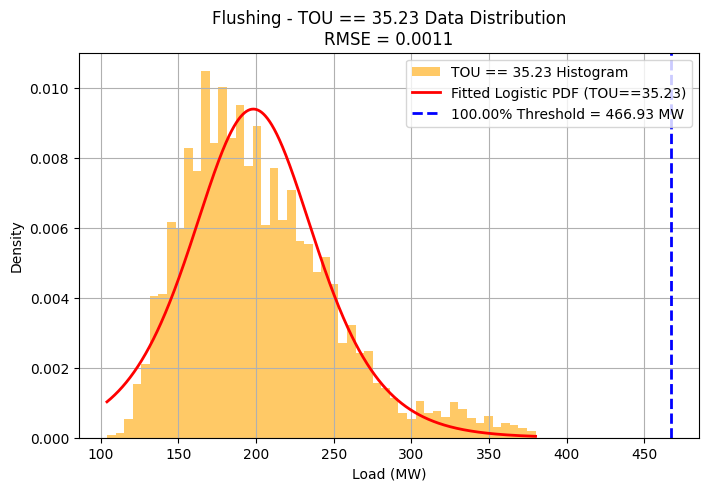

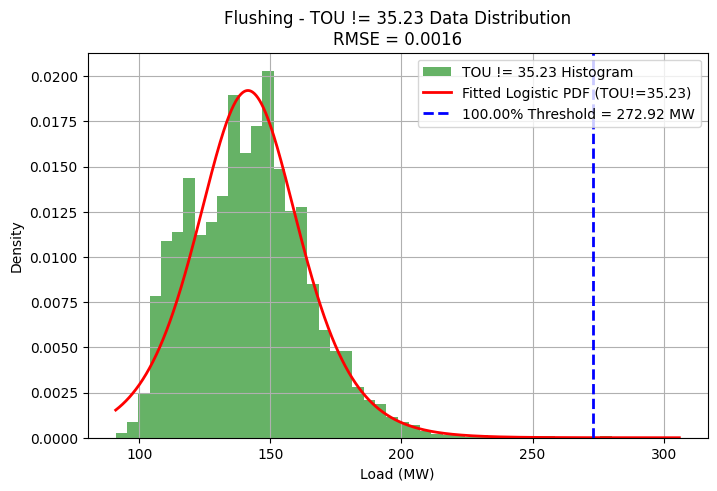

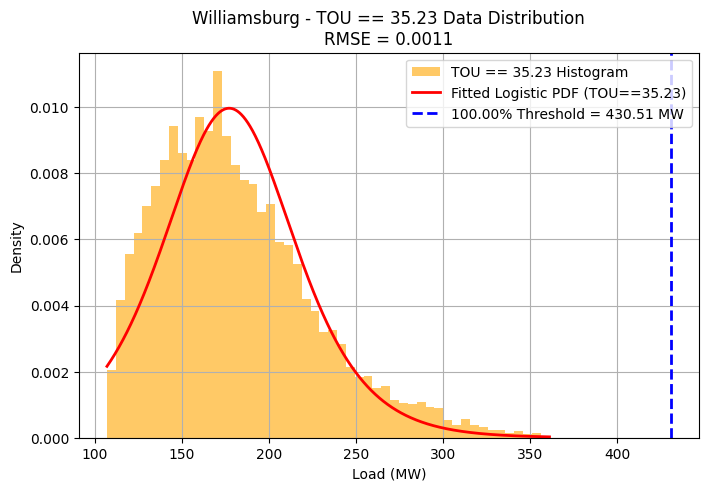

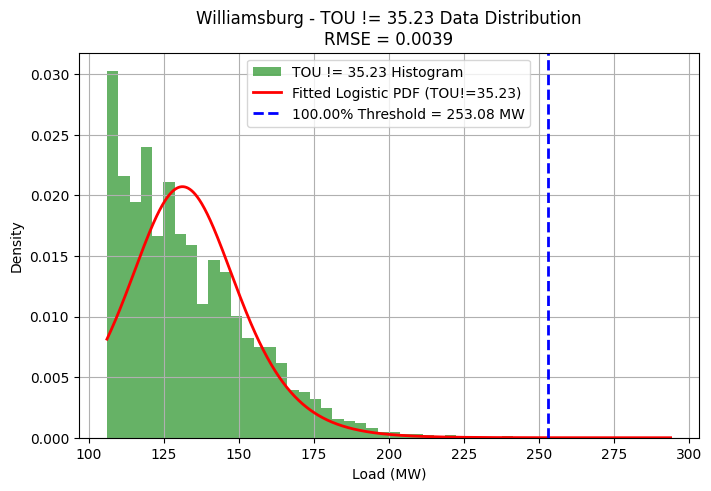

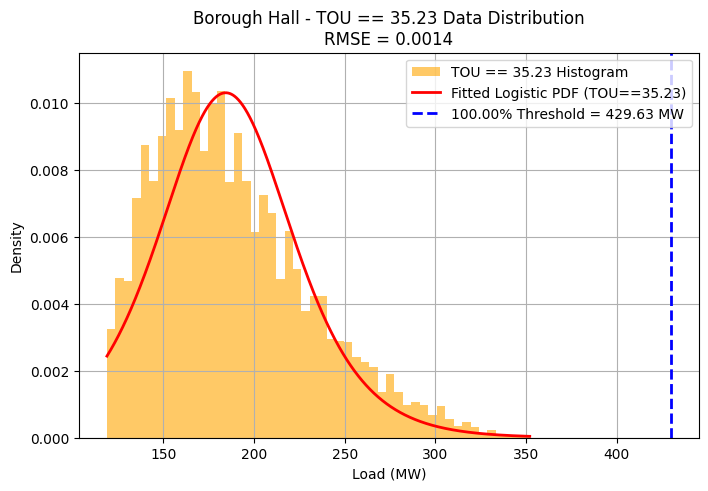

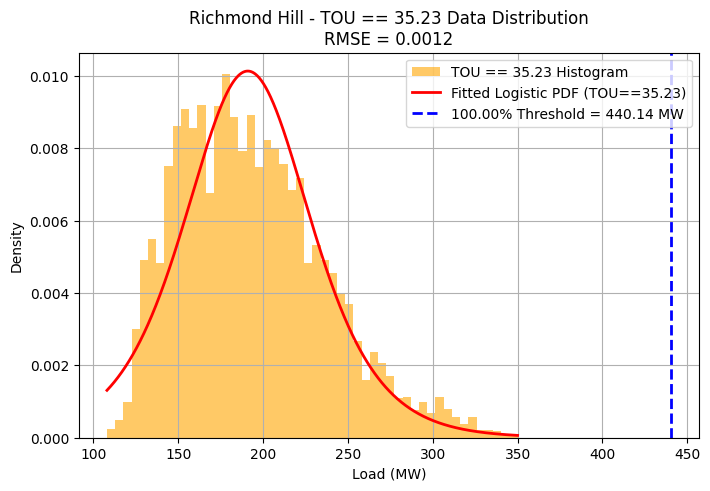

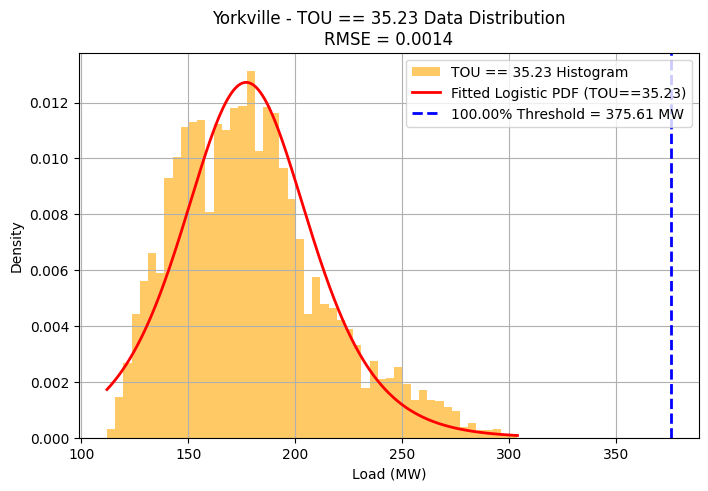

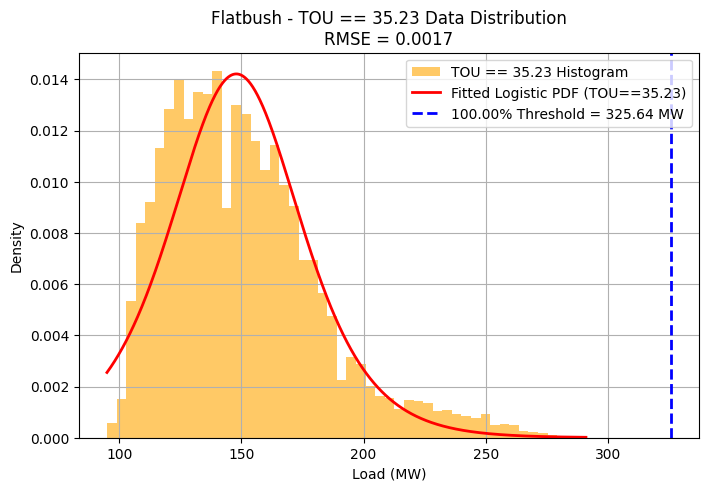

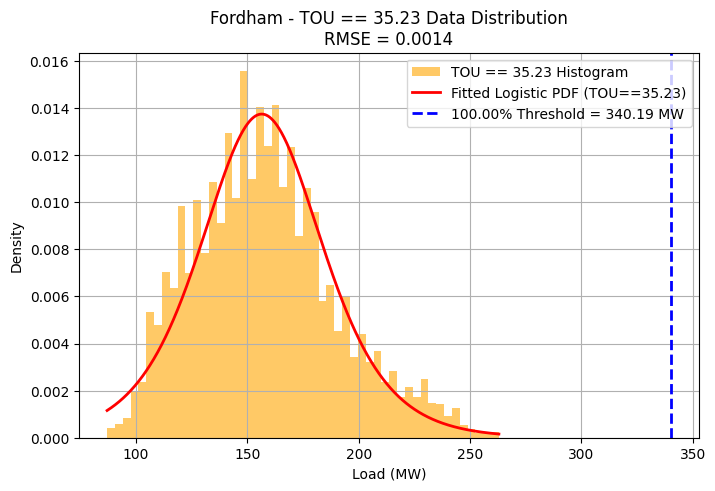

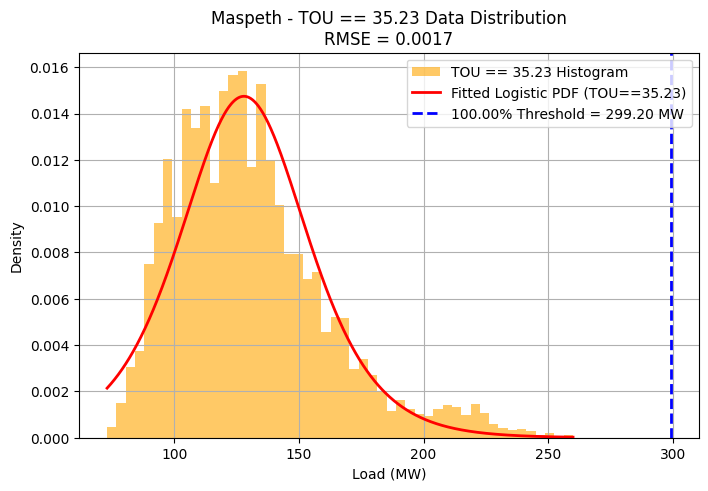

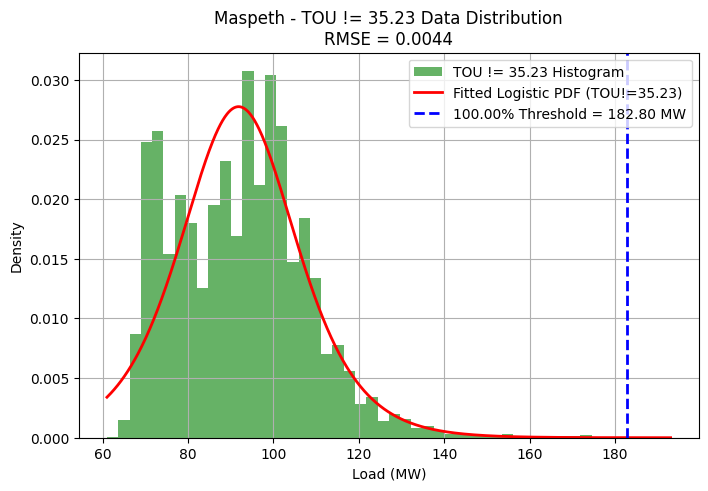

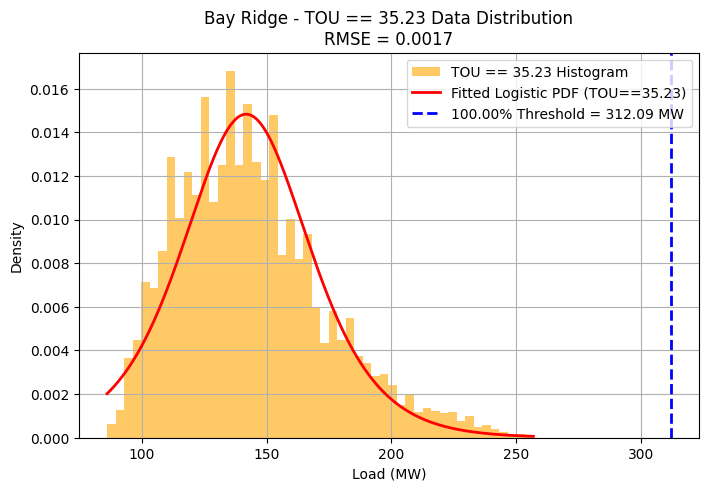

Thresholds and RMSE for TOU == 35.23:
Jamaica: 528.44 MW, RMSE = 0.0012
Flushing: 466.93 MW, RMSE = 0.0011
Williamsburg: 430.51 MW, RMSE = 0.0011
Borough Hall: 429.63 MW, RMSE = 0.0014
Richmond Hill: 440.14 MW, RMSE = 0.0012
Yorkville: 375.61 MW, RMSE = 0.0014
Flatbush: 325.64 MW, RMSE = 0.0017
Fordham: 340.19 MW, RMSE = 0.0014
Maspeth: 299.20 MW, RMSE = 0.0017
Bay Ridge: 312.09 MW, RMSE = 0.0017
Madison Square: 308.67 MW, RMSE = 0.0022
Lenox Hill: 297.39 MW, RMSE = 0.0016
Long Island City: 309.58 MW, RMSE = 0.0018
White Plains: 269.00 MW, RMSE = 0.0022
West Bronx: 300.52 MW, RMSE = 0.0017
Cooper Square: 297.56 MW, RMSE = 0.0016
Ridgewood: 294.20 MW, RMSE = 0.0017
Chelsea: 276.03 MW, RMSE = 0.0029
Crown Heights: 263.15 MW, RMSE = 0.0022
Park Slope: 262.90 MW, RMSE = 0.0020
Rego Park: 254.38 MW, RMSE = 0.0021
Granite Hill: 254.48 MW, RMSE = 0.0031
Fox Hills: 254.94 MW, RMSE = 0.0027
Harlem: 265.15 MW, RMSE = 0.0028
Harrison: 250.33 MW, RMSE = 0.0022
Southeast Bronx: 271.61 MW, RMSE = 0.

In [ ]:
from scipy.stats import logistic
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set the desired confidence level (e.g., 99.9% here)
confidence_level = 24399 / 24400

# Dictionaries to hold thresholds and RMSE values for each network for the two partitions
thresholds_tou_eq = {}   # For TOU == 35.23
thresholds_tou_neq = {}  # For TOU != 35.23
rmse_tou_eq = {}
rmse_tou_neq = {}

# Loop over each network in top_areas (assumed defined already)
for area in top_areas:
    # Partition the data based on 'time_of_use_rate'
    data_tou_eq = loads_df[loads_df["time_of_use_rate"] == 35.23][area].values
    data_tou_neq = loads_df[loads_df["time_of_use_rate"] != 35.23][area].values

    # --- TOU == 35.23 Partition ---
    # Fit a logistic distribution to the TOU == 35.23 subset
    loc_eq, scale_eq = logistic.fit(data_tou_eq)
    # Compute threshold from the logistic model
    threshold_eq = logistic.ppf(confidence_level, loc=loc_eq, scale=scale_eq)
    thresholds_tou_eq[area] = threshold_eq

    # Compute empirical density using a histogram
    hist_counts_eq, hist_bins_eq = np.histogram(data_tou_eq, bins=50, density=True)
    bin_centers_eq = (hist_bins_eq[:-1] + hist_bins_eq[1:]) / 2
    pdf_eq_pred = logistic.pdf(bin_centers_eq, loc=loc_eq, scale=scale_eq)
    rmse_eq = np.sqrt(np.mean((hist_counts_eq - pdf_eq_pred)**2))
    rmse_tou_eq[area] = rmse_eq

    # Plot for TOU == 35.23 subset
    x_eq = np.linspace(data_tou_eq.min(), data_tou_eq.max(), 1000)
    pdf_eq = logistic.pdf(x_eq, loc=loc_eq, scale=scale_eq)
    if area in ['Jamaica', 'Flushing', 'Williamsburg', 'Borough Hall', 'Richmond Hill', 'Yorkville', 'Flatbush', 'Fordham', 'Maspeth', 'Bay Ridge']:
      plt.figure(figsize=(8, 5))
      plt.hist(data_tou_eq, bins=50, density=True, alpha=0.6, color='orange',
              label='TOU == 35.23 Histogram')
      plt.plot(x_eq, pdf_eq, 'r-', lw=2, label='Fitted Logistic PDF (TOU==35.23)')
      plt.axvline(threshold_eq, color='blue', linestyle='--', lw=2,
                  label=f"{confidence_level*100:.2f}% Threshold = {threshold_eq:.2f} MW")
      plt.title(f"{area} - TOU == 35.23 Data Distribution\nRMSE = {rmse_eq:.4f}")
      plt.xlabel("Load (MW)")
      plt.ylabel("Density")
      plt.legend()
      plt.grid(True)
      plt.show()

    # --- TOU != 35.23 Partition ---
    # Fit a logistic distribution to the TOU != 35.23 subset
    loc_neq, scale_neq = logistic.fit(data_tou_neq)
    threshold_neq = logistic.ppf(confidence_level, loc=loc_neq, scale=scale_neq)
    thresholds_tou_neq[area] = threshold_neq

    # Compute empirical density and RMSE for this partition
    hist_counts_neq, hist_bins_neq = np.histogram(data_tou_neq, bins=50, density=True)
    bin_centers_neq = (hist_bins_neq[:-1] + hist_bins_neq[1:]) / 2
    pdf_neq_pred = logistic.pdf(bin_centers_neq, loc=loc_neq, scale=scale_neq)
    rmse_neq = np.sqrt(np.mean((hist_counts_neq - pdf_neq_pred)**2))
    rmse_tou_neq[area] = rmse_neq

    # Plot for TOU != 35.23 subset
    x_neq = np.linspace(data_tou_neq.min(), data_tou_neq.max(), 1000)
    pdf_neq = logistic.pdf(x_neq, loc=loc_neq, scale=scale_neq)
    if area in ['Jamaica', 'Flushing', 'Williamsburg', 'Maspeth']:
      plt.figure(figsize=(8, 5))
      plt.hist(data_tou_neq, bins=50, density=True, alpha=0.6, color='green',
              label='TOU != 35.23 Histogram')
      plt.plot(x_neq, pdf_neq, 'r-', lw=2, label='Fitted Logistic PDF (TOU!=35.23)')
      plt.axvline(threshold_neq, color='blue', linestyle='--', lw=2,
                  label=f"{confidence_level*100:.2f}% Threshold = {threshold_neq:.2f} MW")
      plt.title(f"{area} - TOU != 35.23 Data Distribution\nRMSE = {rmse_neq:.4f}")
      plt.xlabel("Load (MW)")
      plt.ylabel("Density")
      plt.legend()
      plt.grid(True)
      plt.show()

# Print the thresholds and RMSE for each network for both partitions
print("Thresholds and RMSE for TOU == 35.23:")
for area, t_val in thresholds_tou_eq.items():
    print(f"{area}: {t_val:.2f} MW, RMSE = {rmse_tou_eq[area]:.4f}")

print("\nThresholds and RMSE for TOU != 35.23:")
for area, t_val in thresholds_tou_neq.items():
    print(f"{area}: {t_val:.2f} MW, RMSE = {rmse_tou_neq[area]:.4f}")

# --- Sort areas by RMSE for each partition ---
sorted_eq = sorted(rmse_tou_eq.items(), key=lambda x: x[1])
sorted_neq = sorted(rmse_tou_neq.items(), key=lambda x: x[1])

# Store the best (lowest RMSE) for each partition in variables
best_area_eq, best_rmse_eq = sorted_eq[0]
best_area_neq, best_rmse_neq = sorted_neq[0]

print("\nBest fit for TOU == 35.23 partition:")
print(f"{best_area_eq} with RMSE = {best_rmse_eq:.4f}")

print("\nBest fit for TOU != 35.23 partition:")
print(f"{best_area_neq} with RMSE = {best_rmse_neq:.4f}")


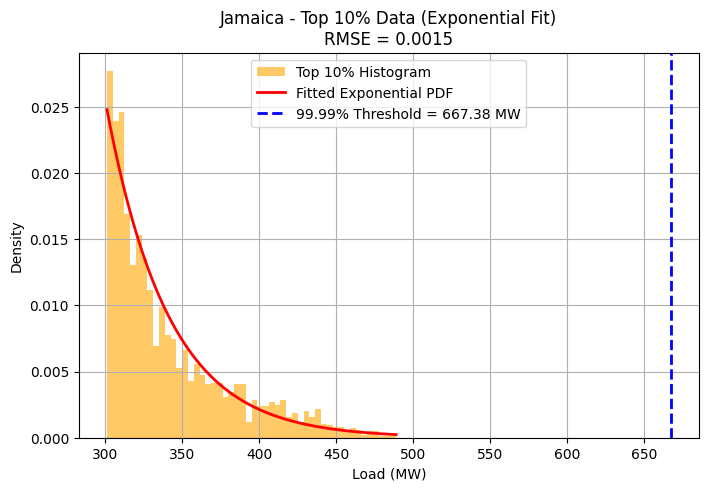

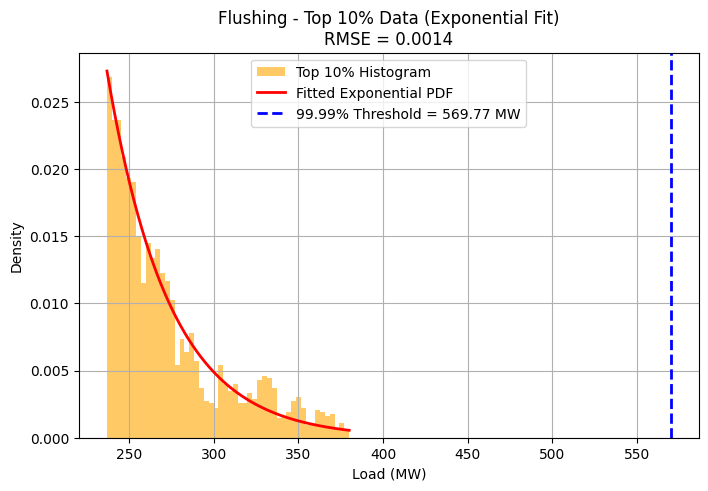

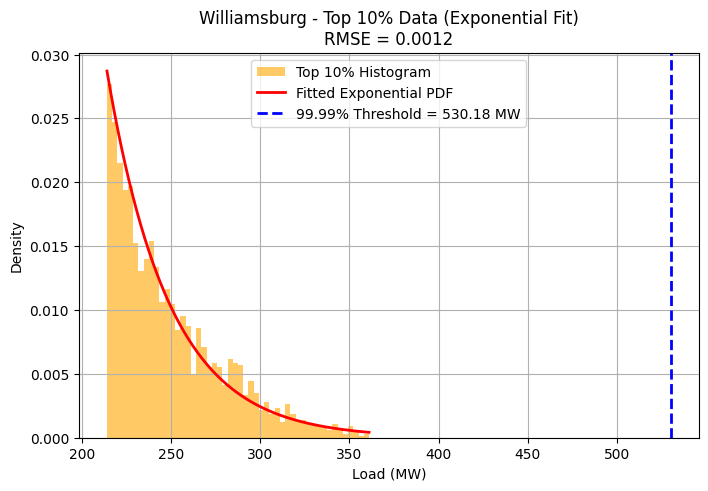

Exponential Fit Thresholds for Top 5% Loads:
Jamaica: 667.38 MW threshold at 99.99% confidence
Flushing: 569.77 MW threshold at 99.99% confidence
Williamsburg: 530.18 MW threshold at 99.99% confidence
Borough Hall: 504.85 MW threshold at 99.99% confidence
Richmond Hill: 492.38 MW threshold at 99.99% confidence
Yorkville: 446.75 MW threshold at 99.99% confidence
Flatbush: 400.14 MW threshold at 99.99% confidence
Fordham: 390.99 MW threshold at 99.99% confidence
Maspeth: 380.99 MW threshold at 99.99% confidence
Bay Ridge: 369.84 MW threshold at 99.99% confidence
Madison Square: 349.76 MW threshold at 99.99% confidence
Lenox Hill: 311.12 MW threshold at 99.99% confidence
Long Island City: 349.07 MW threshold at 99.99% confidence
White Plains: 360.79 MW threshold at 99.99% confidence
West Bronx: 347.31 MW threshold at 99.99% confidence
Cooper Square: 339.51 MW threshold at 99.99% confidence
Ridgewood: 334.56 MW threshold at 99.99% confidence
Chelsea: 328.85 MW threshold at 99.99% confidenc

In [ ]:
from scipy.stats import expon
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set the desired confidence level (e.g., 99% here)
confidence_level = 8759 / 8760

# Dictionaries to hold thresholds and RMSE for each network (top 10% partition using exponential fit)
thresholds_top10_exp = {}
rmse_dict = {}

# Loop over each network in top_areas (assumed defined already)
for area in top_areas:
    # Get all load data for the network from loads_df
    data_all = loads_df[area].values

    # Determine the 90th percentile load value
    quantile_95 = np.quantile(data_all, 0.95)

    # Partition the data into the top 10% (data >= the 90th percentile)
    data_top10 = data_all[data_all >= quantile_95]

    # Fit an exponential distribution to the top 10% subset.
    # expon.fit will estimate both a location (loc) and scale parameter.
    loc, scale = expon.fit(data_top10)

    # Compute the threshold from the exponential model at the desired confidence level.
    threshold_value = expon.ppf(confidence_level, loc=loc, scale=scale)
    thresholds_top10_exp[area] = threshold_value

    # --- Calculate RMSE for the fit ---
    # Compute an empirical density estimate using a histogram:
    hist_counts, hist_bins = np.histogram(data_top10, bins=50, density=True)
    bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2
    # Evaluate the fitted PDF at the histogram bin centers
    pdf_pred = expon.pdf(bin_centers, loc=loc, scale=scale)
    # Calculate RMSE between the histogram (observed density) and the fitted PDF
    rmse = np.sqrt(np.mean((hist_counts - pdf_pred)**2))
    rmse_dict[area] = rmse

    # --- Plotting for this network ---
    if area in ['Jamaica', 'Flushing', 'Williamsburg']:
      x = np.linspace(data_top10.min(), data_top10.max(), 1000)
      pdf_expon = expon.pdf(x, loc=loc, scale=scale)

      plt.figure(figsize=(8, 5))
      plt.hist(data_top10, bins=50, density=True, alpha=0.6, color='orange',
              label='Top 10% Histogram')
      plt.plot(x, pdf_expon, 'r-', lw=2, label='Fitted Exponential PDF')
      plt.axvline(threshold_value, color='blue', linestyle='--', lw=2,
                  label=f"{confidence_level*100:.2f}% Threshold = {threshold_value:.2f} MW")
      plt.title(f"{area} - Top 10% Data (Exponential Fit)\nRMSE = {rmse:.4f}")
      plt.xlabel("Load (MW)")
      plt.ylabel("Density")
      plt.legend()
      plt.grid(True)
      plt.show()

# Print the thresholds for each network
print("Exponential Fit Thresholds for Top 5% Loads:")
for area, threshold_value in thresholds_top10_exp.items():
    print(f"{area}: {threshold_value:.2f} MW threshold at {confidence_level*100:.2f}% confidence")

# --- Sort areas by RMSE (lowest first) and store the best one ---
sorted_rmse_exp = sorted(rmse_dict.items(), key=lambda x: x[1])
best_area, best_rmse = sorted_rmse_exp[0]

print("\nSorted RMSE by Area (lowest first):")
for area, rmse in sorted_rmse_exp:
    print(f"{area}: RMSE = {rmse:.4f}")

print(f"\nBest fitting area (lowest RMSE): {best_area} with RMSE = {best_rmse:.4f}")


In [ ]:
# Assuming each sorted list is a list of tuples: (network, value)
rmse_values = [value for network, value in sorted_rmse]
eq_values = [value for network, value in sorted_eq]
rmse_exp_values = [value for network, value in sorted_rmse_exp]

average_rmse = sum(rmse_values) / len(rmse_values)
average_eq = sum(eq_values) / len(eq_values)
average_rmse_exp = sum(rmse_exp_values) / len(rmse_exp_values)

averages = [average_rmse, average_eq, average_rmse_exp]
print("Averages:", averages)

Averages: [0.004867398842387624, 0.003231887906631512, 0.006971168942901444]


The bimodal fit has the lowest RMSE so I will use the bimodal model to estimate the peak thresholds.

### Battery Addresable Load Model

In [ ]:
import pandas as pd
import numpy as np

def find_battery_addressable_load(load_series, tol=1e-6, max_iter=100):
    """
    For a given load series (in MW), find x (in MW) such that for each day,
      max_daily_shaved_energy = max_over_days(sum(max(0, load - (L_max - x)))
      is less than or equal to 4*x.
    Here, L_max is the maximum load over the entire period.

    The battery addressable load x is defined so that a battery sized at 4*x MWh
    can shave the maximum daily excess load. Because charging occurs at night,
    the lower bound for x is set to 90% of L_max.

    Returns:
      dispatch_threshold (MW) = L_max - x,
      x: battery addressable load (MW),
      pct: x as a percentage of L_max.
    """
    L_max = load_series.max()

    # Set lower bound to 90% of L_max and upper bound to L_max.
    lb = 1e-6
    ub = L_max

    # Define g(x) = 4*x - max_daily_shaved_energy, where for each day,
    # daily_shaved_energy = sum(max(0, load - (L_max - x)))
    # and we use the maximum value across days.
    def g(x):
        threshold = L_max - x
        # Compute the shaved energy for each day using the global loads_df day column.
        daily_shaved_sum = load_series.sub(threshold).clip(lower=0).groupby(loads_df['Day']).sum()
        max_daily_shaved = daily_shaved_sum.max()
        return 4 * x - max_daily_shaved

    # Check if even a very large battery (x = L_max) would be sufficient.
    if g(ub) >= 0:
        x = L_max
        pct = 100.0
        dispatch_threshold = L_max - x
        return dispatch_threshold, x, pct

    # Binary search: find the largest x (between lb and L_max) for which g(x) >= 0.
    for _ in range(max_iter):
        mid = (lb + ub) / 2
        if g(mid) >= 0:
            lb = mid
        else:
            ub = mid
        if abs(ub - lb) < tol:
            break

    x = lb
    pct = (x / L_max) * 100
    dispatch_threshold = L_max - x
    return dispatch_threshold, x, pct

# Assume your DataFrame is called loads_df.
# Identify the columns that contain network load data.
# (Here we assume the meta columns are named as shown.)
meta_cols = ['Day', 'Hour', 'standard_rate', 'time_of_use_rate', 'Peak_bool']
network_cols = top_areas
loads_df = loads_df[meta_cols + network_cols]

# Create a results dictionary.
results = {}
for col in network_cols:
    dispatch_threshold, x, pct = find_battery_addressable_load(loads_df[col])
    results[col] = {
        'dispatch_threshold_MW': dispatch_threshold,
        'battery_addressable_load_MW': x,
        'percentage_of_max': pct
    }
    print(f"Network: {col}")
    print(f"Dispatch Threshold (MW): {dispatch_threshold}")
    print(f"Battery Addressable Load (MW): {x}")

# Convert results to a DataFrame and display it.
results_df = pd.DataFrame(results).T
print(results_df)


Network: Jamaica
Dispatch Threshold (MW): 454.3333335149837
Battery Addressable Load (MW): 34.66666648501629
Network: Flushing
Dispatch Threshold (MW): 343.40000032417146
Battery Addressable Load (MW): 36.59999967582853
Network: Williamsburg
Dispatch Threshold (MW): 345.3333337110061
Battery Addressable Load (MW): 15.666666288993893
Network: Borough Hall
Dispatch Threshold (MW): 322.6666668427518
Battery Addressable Load (MW): 29.333333157248184
Network: Richmond Hill
Dispatch Threshold (MW): 309.2500006326217
Battery Addressable Load (MW): 40.74999936737828
Network: Yorkville
Dispatch Threshold (MW): 294.3333335671586
Battery Addressable Load (MW): 9.666666432841422
Network: Flatbush
Dispatch Threshold (MW): 263.00000031811516
Battery Addressable Load (MW): 27.99999968188486
Network: Fordham
Dispatch Threshold (MW): 245.0000009043396
Battery Addressable Load (MW): 20.999999095660392
Network: Maspeth
Dispatch Threshold (MW): 229.00000096697477
Battery Addressable Load (MW): 30.99999903

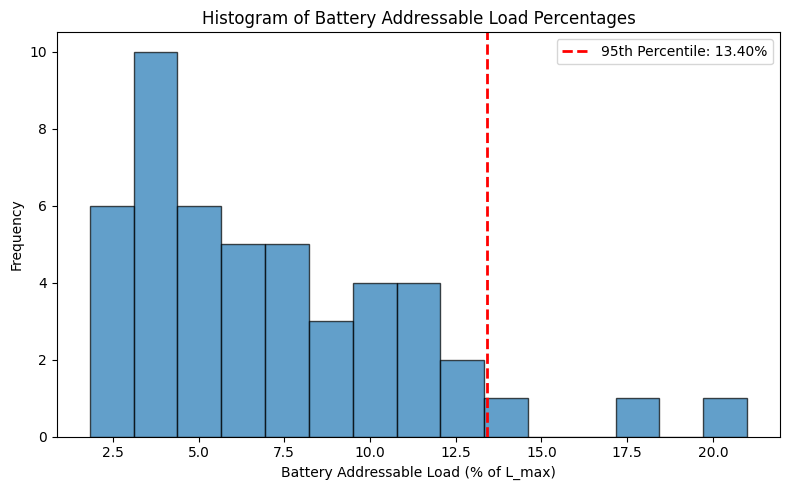

95th Percentile (Battery Addressable Load as % of L_max): 13.40%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract percentage values from results_df.
pct_values = results_df['percentage_of_max'].values

# Plot histogram.
plt.figure(figsize=(8, 5))
plt.hist(pct_values, bins=15, edgecolor='k', alpha=0.7)
plt.xlabel('Battery Addressable Load (% of L_max)')
plt.ylabel('Frequency')
plt.title('Histogram of Battery Addressable Load Percentages')

# Compute the 95th percentile.
threshold_95 = np.percentile(pct_values, 95)

# Plot the 95th percentile on the histogram.
plt.axvline(threshold_95, color='red', linestyle='--', linewidth=2,
            label=f'95th Percentile: {threshold_95:.2f}%')
plt.legend()
plt.tight_layout()
plt.show()

# Print the 95th percentile.
print(f"95th Percentile (Battery Addressable Load as % of L_max): {threshold_95:.2f}%")


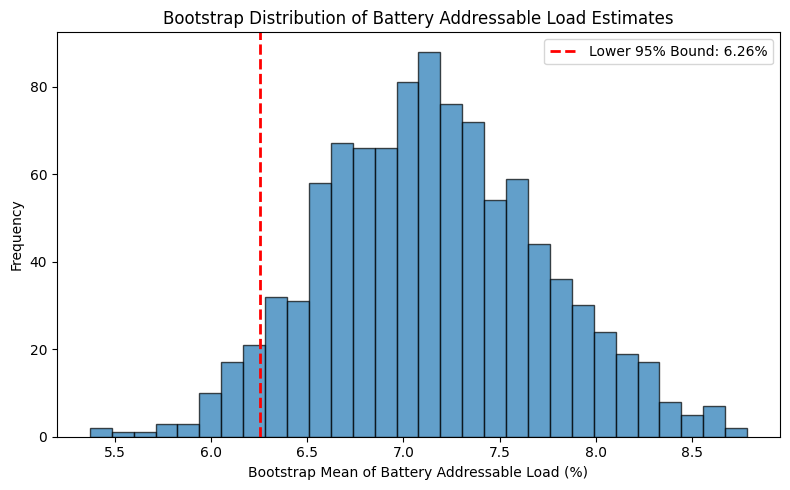

Lower 95% Confidence Bound for Battery Addressable Percentage: 6.26%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract the percentage values from results_df.
pct_values = results_df['percentage_of_max'].values

# Number of bootstrap iterations.
n_iterations = 1000
bootstrap_estimates = []

# Bootstrap: resample the percentage values with replacement and compute a summary statistic.
# Here, we use the mean of the resampled percentages.
for _ in range(n_iterations):
    sample = np.random.choice(pct_values, size=len(pct_values), replace=True)
    bootstrap_estimates.append(np.mean(sample))

bootstrap_estimates = np.array(bootstrap_estimates)

# Compute the lower 95% confidence bound (5th percentile) of the bootstrap estimates.
lower_bound = np.percentile(bootstrap_estimates, 5)

# Plot the distribution of bootstrap estimates.
plt.figure(figsize=(8, 5))
plt.hist(bootstrap_estimates, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(lower_bound, color='red', linestyle='--', linewidth=2,
            label=f'Lower 95% Bound: {lower_bound:.2f}%')
plt.xlabel('Bootstrap Mean of Battery Addressable Load (%)')
plt.ylabel('Frequency')
plt.title('Bootstrap Distribution of Battery Addressable Load Estimates')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Lower 95% Confidence Bound for Battery Addressable Percentage: {lower_bound:.2f}%")


In [ ]:
# Filter out networks where both battery_addressable_load_MW and percentage_of_max are less than 5.
results_df= results_df[~((results_df['battery_addressable_load_MW'] < 10) &
                                    (results_df['percentage_of_max'] < 10))]

# Update the network_cols list to only include the filtered networks.
filtered_network_cols = results_df[((results_df['battery_addressable_load_MW'] < 10) &
                                    (results_df['percentage_of_max'] < 10))]

print("Filtered Networks:")
print(filtered_network_cols)
print("\nNew Results DataFrame:")
print(results_df)


Filtered Networks:
Empty DataFrame
Columns: [dispatch_threshold_MW, battery_addressable_load_MW, percentage_of_max]
Index: []

New Results DataFrame:
                   dispatch_threshold_MW  battery_addressable_load_MW  \
Jamaica                       454.333334                    34.666666   
Flushing                      343.400000                    36.600000   
Williamsburg                  345.333334                    15.666666   
Borough Hall                  322.666667                    29.333333   
Richmond Hill                 309.250001                    40.749999   
Flatbush                      263.000000                    28.000000   
Fordham                       245.000001                    20.999999   
Maspeth                       229.000001                    30.999999   
Bay Ridge                     243.500000                    13.500000   
Madison Square                235.000000                    11.000000   
Lenox Hill                    220.800000       

## Validating Models / Threshold Dispatch Controller Model

In [ ]:
import numpy as np
import pandas as pd

# -------------------------------
# Parameters
grid_upgrade_cost_per_MW = 200000    # dollars per MW of grid upgrade capacity deferred
battery_install_cost_per_MWh = 30000   # dollars per MWh installed (battery installation)

# We assume that the battery sizing results are already stored in results_df
# with index corresponding to network column names and columns:
# 'battery_addressable_load_MW' and 'percentage_of_max'
#
# For each network, we use:
#   battery_power = battery_addressable_load_MW (in MW)
#   battery_capacity = 4 * battery_power (in MWh)

# List of network columns (from results_df index)
network_cols = results_df.index.tolist()
print(network_cols)

# Dictionary to store simulation metrics from the simulation loop.
simulation_metrics = {}
# List to store time-series details across networks.
all_details = []

# Loop over each network column to simulate battery dispatch.
for net in network_cols:
    # Battery sizing from previous results:
    battery_power = results_df.loc[net, 'battery_addressable_load_MW']  # MW
    battery_capacity = 4 * battery_power  # MWh

    # Get the original load series for the network.
    original_load = loads_df[net]
    original_max_load = original_load.max()

    # Define dispatch threshold:
    # Battery discharges only if load exceeds (original_max_load - battery_power)
    dispatch_threshold = original_max_load - battery_power

    # Preallocate an array for the effective load profile.
    n_hours = len(original_load)
    effective_load_profile = np.empty(n_hours, dtype=float)

    # Initialize battery state-of-charge (SOC).
    SOC = battery_capacity

    # List to hold detailed simulation records for this network.
    detailed_records = []

    # Run the simulation for each hour.
    for i in range(n_hours):
        hour = i % 24
        load = original_load.iloc[i]

        # Initialize control_action for this timestep.
        control_action = 0.0

        if hour < 8:
            # Off-peak: charge at rate battery_power/2 (but do not exceed capacity).
            charge_rate = battery_power / 2.0
            charge = min(charge_rate, battery_capacity - SOC)
            SOC += charge
            effective_load = load + charge
            control_action = charge  # positive value indicates charging
        else:
            # Peak: discharge if load exceeds dispatch threshold.
            if load > dispatch_threshold:
                desired_discharge = load - dispatch_threshold
                discharge = min(desired_discharge, battery_power, SOC)
                SOC -= discharge
                effective_load = load - discharge
                control_action = -discharge  # negative value indicates discharging
            else:
                effective_load = load
                control_action = 0.0

        effective_load_profile[i] = effective_load
        day = loads_df.Day.iloc[i]
        hour = loads_df.Hour.iloc[i]

        # Record the details for this timestep.
        detailed_records.append({
            'Network': net,
            'Day': day,
            'Hour': hour,
            'Load': load,
            'Battery_SOC': SOC,
            'Control_Action': control_action,
            'Effective_Load': load/battery_power,
            'Effective_Battery_SOC': SOC/battery_power,
            'Effective_Control_Action': control_action/battery_power
        })

    # Extend the overall list with this network's details.
    all_details.extend(detailed_records)

    # Compute simulation metrics for this network.
    effective_max_load = effective_load_profile.max()
    grid_upgrade_deferred = (original_max_load - effective_max_load) * grid_upgrade_cost_per_MW
    battery_cost = battery_capacity * battery_install_cost_per_MWh
    net_savings = grid_upgrade_deferred - battery_cost

    simulation_metrics[net] = {
        'battery_addressable_load_MW': battery_power,  # Added for comparison
        'dispatch_threshold_MW': dispatch_threshold,
        'effective_max_load_MW': effective_max_load,
        'grid_upgrade_deferred_$': grid_upgrade_deferred,
        'battery_capacity_MWh': battery_capacity,
        'battery_install_cost_$': battery_cost,
        'net_savings_$': net_savings
    }

# Convert simulation metrics to a DataFrame.
sim_df = pd.DataFrame(simulation_metrics).T

# -------------------------------
# Compare the simulation battery addressable load with that in results_df.
common_cols = ['battery_addressable_load_MW']

# Use pandas compare to identify differences.
differences = results_df[common_cols].compare(sim_df[common_cols])

if differences.empty:
    print("Simulation battery addressable load matches the values in results_df.")
else:
    print("Differences found between simulation battery addressable load and results_df:")
    print(differences)

# -------------------------------
# Create a detailed DataFrame with the simulation time-series records.
detailed_df = pd.DataFrame(all_details)
print("\nDetailed simulation records (first few rows):")
print(detailed_df.head())


['Jamaica', 'Flushing', 'Williamsburg', 'Borough Hall', 'Richmond Hill', 'Flatbush', 'Fordham', 'Maspeth', 'Bay Ridge', 'Madison Square', 'Lenox Hill', 'Long Island City', 'White Plains', 'West Bronx', 'Cooper Square', 'Ridgewood', 'Chelsea', 'Park Slope', 'Rego Park', 'Granite Hill', 'Fox Hills', 'Harrison', 'Southeast Bronx', 'Jackson Heights', 'Washington Street', 'Grand Central', 'Ocean Parkway', 'Elmsford No. 2', 'Grasslands', 'Buchanan']
Simulation battery addressable load matches the values in results_df.

Detailed simulation records (first few rows):
   Network  Day  Hour  Load  Battery_SOC  Control_Action  Effective_Load  \
0  Jamaica    0     0   237   138.666666             0.0        6.836538   
1  Jamaica    0     1   226   138.666666             0.0        6.519231   
2  Jamaica    0     2   220   138.666666             0.0        6.346154   
3  Jamaica    0     3   216   138.666666             0.0        6.230769   
4  Jamaica    0     4   215   138.666666             0.

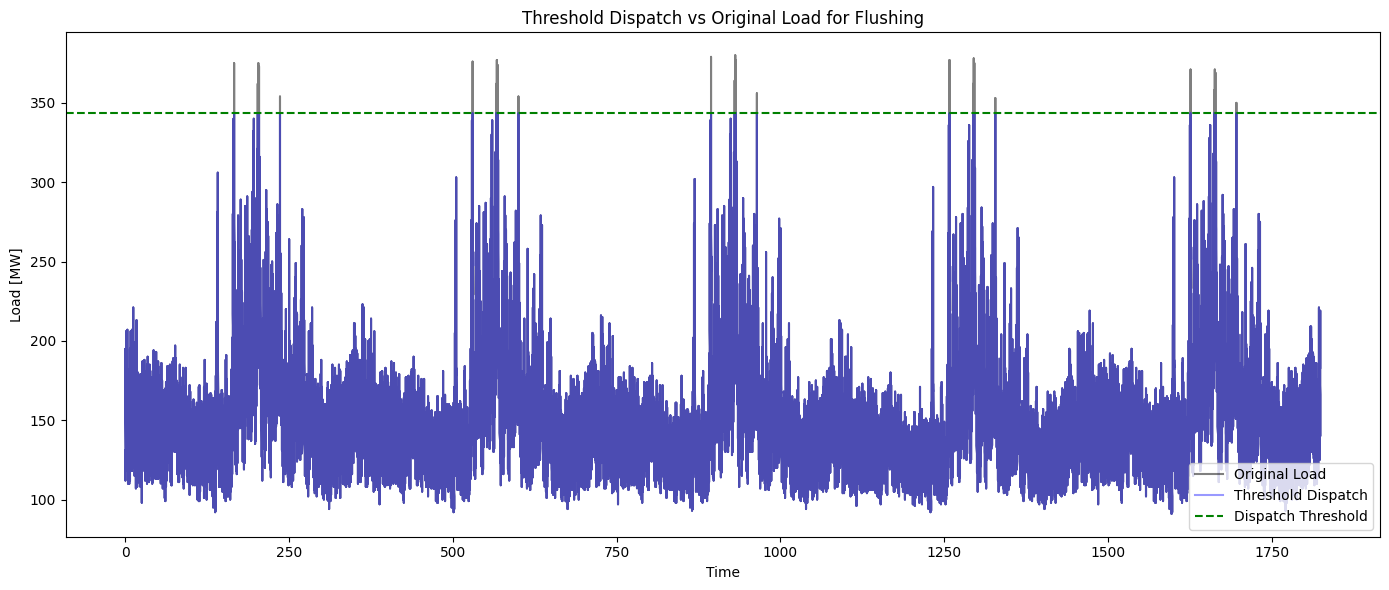

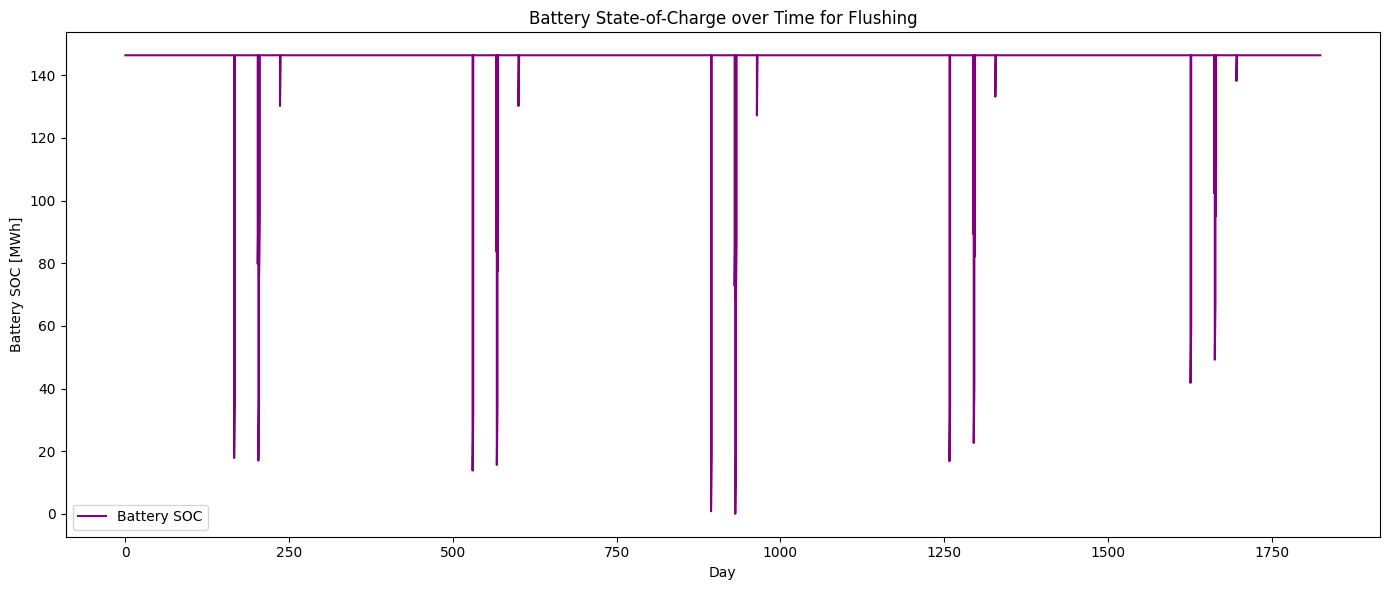

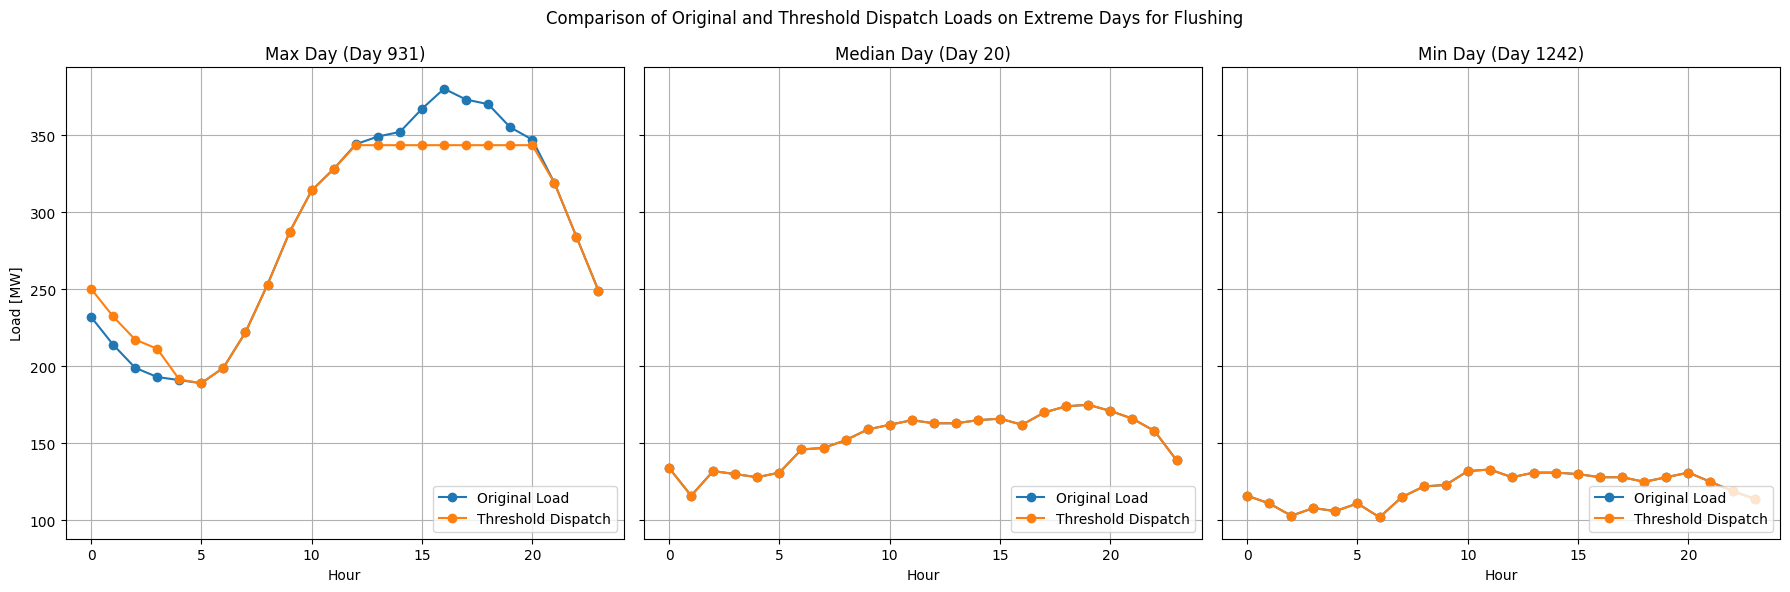

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------
# Select a network for plotting.
# Use 'Jamaica' if present; otherwise, use the first network from results_df.
selected_net = results_df.index[1]

# Filter the detailed_df for the selected network.
net_details = detailed_df[detailed_df['Network'] == selected_net].copy()

# Compute the effective load from the simulation: Controlled_Load = Load + Control_Action.
net_details['Controlled_Load'] = net_details['Load'] + net_details['Control_Action']

# Set the index of net_details to the simulation time.
net_details.set_index('Day', inplace=True)

# Retrieve the original load series for the selected network.
original_load = loads_df[selected_net]

# Retrieve dispatch threshold for the selected network from results_df.
dispatch_threshold = results_df.loc[selected_net, 'dispatch_threshold_MW']

# -------------------------------
# Plot 1: Load Profiles and Dispatch Threshold
plt.figure(figsize=(14, 6))
plt.plot(net_details.index, original_load, label='Original Load', color='black', alpha=0.5)
plt.plot(net_details.index, net_details['Controlled_Load'], label='Threshold Dispatch', color='blue', alpha=0.4)
plt.axhline(dispatch_threshold, color='green', linestyle='--', label='Dispatch Threshold')
plt.xlabel('Time')
plt.ylabel('Load [MW]')
plt.title(f'Threshold Dispatch vs Original Load for {selected_net}')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# -------------------------------
# Plot 2: Battery SOC Over Time
plt.figure(figsize=(14, 6))
plt.plot(net_details.index, net_details['Battery_SOC'], label='Battery SOC', color='purple')
plt.xlabel('Day')
plt.ylabel('Battery SOC [MWh]')
plt.title(f'Battery State-of-Charge over Time for {selected_net}')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# -------------------------------
# Plot 3: Extreme Days Comparison
# Build a DataFrame for the selected network including Hour and Day info.
# We assume that loads_df has meta columns 'Hour' and 'Day'.
df_plot = loads_df[[selected_net, 'Hour', 'Day']].copy()
# Add the effective load from the simulation.
# Assumes the index of net_details aligns with loads_df's index.
df_plot['Threshold Dispatch'] = net_details['Controlled_Load'].values

# Group by 'Day' to compute the daily maximum load from the original load.
daily_max_original = df_plot.groupby('Day')[selected_net].max()

# Identify the extreme days.
max_day = daily_max_original.idxmax()
min_day = daily_max_original.idxmin()
median_day = (daily_max_original - daily_max_original.median()).abs().idxmin()

# Filter the DataFrame for these days.
df_max_day = df_plot[df_plot['Day'] == max_day]
df_median_day = df_plot[df_plot['Day'] == median_day]
df_min_day = df_plot[df_plot['Day'] == min_day]

# Plot the results side by side.
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for the day with maximum peak load.
axs[0].plot(df_max_day['Hour'], df_max_day[selected_net], marker='o', label='Original Load')
axs[0].plot(df_max_day['Hour'], df_max_day['Threshold Dispatch'], marker='o', label='Threshold Dispatch')
axs[0].set_title(f'Max Day (Day {max_day})')
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Load [MW]')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# Plot for the day with median peak load.
axs[1].plot(df_median_day['Hour'], df_median_day[selected_net], marker='o', label='Original Load')
axs[1].plot(df_median_day['Hour'], df_median_day['Threshold Dispatch'], marker='o', label='Threshold Dispatch')
axs[1].set_title(f'Median Day (Day {median_day})')
axs[1].set_xlabel('Hour')
axs[1].legend(loc='lower right')
axs[1].grid(True)

# Plot for the day with minimum peak load.
axs[2].plot(df_min_day['Hour'], df_min_day[selected_net], marker='o', label='Original Load')
axs[2].plot(df_min_day['Hour'], df_min_day['Threshold Dispatch'], marker='o', label='Threshold Dispatch')
axs[2].set_title(f'Min Day (Day {min_day})')
axs[2].set_xlabel('Hour')
axs[2].legend(loc='lower right')
axs[2].grid(True)

plt.suptitle(f'Comparison of Original and Threshold Dispatch Loads on Extreme Days for {selected_net}')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Assumptions:
# - results_df contains the battery sizing results with index labels for networks.
# - The flushing profile for the chosen network is provided as a pandas Series named flushing_profile.
# - grid_upgrade_cost_per_MW and battery_install_cost_per_MWh are predefined.
#
# For the selected network, the battery power (in MW) is taken from results_df.
# Battery capacity is computed as 4 times the battery power (in MWh).
# The dispatch threshold is defined as:
#      original_max_load - battery_power - 20 MW (20 MW lower than the ideal threshold).

# Choose a network (for example, use the first one in results_df)
selected_net = results_df.index[1]

# Retrieve battery sizing for the network.
battery_power = results_df.loc[selected_net, 'battery_addressable_load_MW']  # MW
battery_capacity = 4 * battery_power  # MWh

# Use the flushing_profile (assumed to be a pandas Series) as the load profile.
original_load = loads_df[selected_net]
original_max_load = original_load.max()

# Compute the dispatch threshold (20 MW lower than the ideal case).
dispatch_threshold = original_max_load - battery_power - 20

# Preallocate array for the effective load profile and initialize battery SOC.
n_hours = len(original_load)
effective_load_profile = np.empty(n_hours, dtype=float)
SOC = battery_capacity

# Simulation loop: For each timestep, discharge if load exceeds threshold; else charge at half the battery power.
for i in range(n_hours):
    load = original_load.iloc[i]

    if load > dispatch_threshold:
        # Discharge: reduce load down to threshold, limited by battery_power and current SOC.
        discharge = min(load - dispatch_threshold, battery_power, SOC)
        SOC -= discharge
        effective_load = load - discharge
    else:
        # Charge: add energy at half the battery power rate, ensuring SOC does not exceed capacity.
        charge_rate = battery_power / 2.0
        charge = min(charge_rate, battery_capacity - SOC)
        SOC += charge
        effective_load = load + charge

    effective_load_profile[i] = effective_load

# Compute simulation metrics.
effective_max_load = effective_load_profile.max()
grid_upgrade_deferred = (original_max_load - effective_max_load) * grid_upgrade_cost_per_MW
battery_cost = battery_capacity * battery_install_cost_per_MWh
net_savings = grid_upgrade_deferred - battery_cost

# Display simulation metrics.
print("Simulation metrics for network:", selected_net)
print("Dispatch threshold (MW):", dispatch_threshold)
print("Effective maximum load (MW):", effective_max_load)
print("Grid upgrade deferred ($):", grid_upgrade_deferred)
print("Battery capacity (MWh):", battery_capacity)
print("Battery installation cost ($):", battery_cost)
print("Net savings ($):", net_savings)

# -------------------------------
# Plot the results.
plt.figure(figsize=(12,6))
plt.plot(original_load.index, original_load, label='Original Load', color='black', alpha=0.5)
plt.plot(original_load.index, effective_load_profile, label='Effective Load (Dispatch Applied)', color='blue', alpha=0.7)
plt.axhline(dispatch_threshold, color='green', linestyle='--', label='Dispatch Threshold (-20 MW)')
plt.xlabel('Time')
plt.ylabel('Load [MW]')
plt.title(f'Battery Dispatch Simulation using Flushing Profile for {selected_net}')
plt.legend()
plt.tight_layout()
plt.show()


## Insights

Cleaning and manipulating time series data can be tricky but also very insightful.

Try lots of things when looking for patterns. Some times visuals are more enlightening than statistics.

I was able to connect what I learn as a mechanical engineer (controllers) to data science!

## Thank you

Special thanks to my Brainstation instructors Tanvi and Arhum who taught me and guided the project.

To anyone looking at this project, here is my email. Feel free to contact me:

asirwatham.gautaman@gmail.com